# Setup

In [5456]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install numpy==2.2.0
import numpy as np
import os
import re
import glob
from tqdm import tqdm
import warnings
import missingno as msno
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

1200404.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [5457]:
# === Setting up Working and Cache Directories ====
WORKING_DIR = "/Users/austincherian/Documents/Capstone/"
CACHE_DIR = os.path.join(WORKING_DIR, "data/cache/")
os.makedirs(CACHE_DIR, exist_ok=True)

In [5458]:
# === Step 1. Loading In Data ====

# Data Dictionary
DICT_PATH = os.path.join(WORKING_DIR, 'data/IO_Austin_Data_Dictionary_2025-06-27.csv')
dict_df = pd.read_csv(DICT_PATH)

# Old Dataset
OLD_DATA_PATH = os.path.join(WORKING_DIR, 'data/IODatabase_Old_cohort_RedCap.csv')
old_data_df = pd.read_csv(OLD_DATA_PATH)


# ==== Step 2. Clean Columns and String Values ====
dict_df.columns = dict_df.columns.str.strip()
old_data_df.columns = old_data_df.columns.str.strip()

for col in dict_df.columns:
    dict_df[col] = dict_df[col].astype(str).str.strip()

# 🧹 Prepare Variable Mapping

In [5459]:
# Lookups for variable labels and types in the dictionary
dict_label_lookup = dict(zip(dict_df['Variable / Field Name'], dict_df['Field Label']))
dict_type_lookup = dict(zip(dict_df['Variable / Field Name'], dict_df['Field Type']))

# Step 3. Prepare Variable Mapping
condition = (
    (dict_df['Candidate / No Candidate'] == 'Candidate') &
    (dict_df['Engineered / Not Engineered'] == 'Not Engineered')
)

candidate_vars_df = dict_df[condition]
criteria_vars_df = dict_df[dict_df['Inclusion / Exclusion Criteria'] == 'Criteria']
old_data_columns = old_data_df.columns

In [5460]:
def find_missing_variables_in_dataset(var_list, data_df):
    """
    Checks a list of raw variable names (var_list) against the provided dataset (data_df),
    using a dictionary lookup to find their human-readable labels and field types.

    Returns:
        - classified_df: A DataFrame with variable name, label, and classification status
        - missing_vars: A list of variable names whose labels were not found in the dataset
    """
    print(f"\n🔍 Checking dictionary variables against dataset...")

    data_columns = data_df.columns
    var_list_labels = [dict_label_lookup.get(v) for v in var_list]
    var_label_lookup = dict(zip(var_list, var_list_labels))

    classified = []
    expanded_list = []
    all_expanded_labels = set()

    for var, label in var_label_lookup.items():
        expanded_vars = []

        # Case 1: Missing label entirely
        if label is None:
            classification = "❌ Missing"
            print(f"\n🔎 Variable: '{var}' → ❌ Label not found in dict_label_lookup")

        # Case 2: Variable is a checkbox — look for expanded columns
        elif dict_type_lookup.get(var) == 'checkbox':
            expanded_labels = [col for col in data_columns if col.startswith(f"{label}")]
            if expanded_labels:
                classification = "🟨 Expanded (Checkbox)"
                print(f"\n🔎 Variable: '{var}' (checkbox) → 🟨 Expanded to {len(expanded_labels)} label(s)")
            else:
                classification = "❌ Missing"
                print(f"\n🔎 Variable: '{var}' (checkbox) → ❌ No derived columns found")

        # Case 3: Direct match to label
        elif any(col == label or col.startswith(label + '.') for col in data_columns):
            # Include label and any ".1", ".2", etc.
            expanded_labels = [col for col in data_columns if col == label or col.startswith(label + '.')]
            classification = "✅ Direct Match" if len(expanded_labels) == 1 else "🟩 Repeating Label"


        # Case 4: Not found at all
        else:
            classification = "❌ Missing"
            print(f"\n🔎 Variable: '{var}' → ❌ Label '{label}' not found in data or not a checkbox")

        # Append classification summary
        classified.append({
            "Variable": var,
            "Display Label": label,
            "Classification": classification,
            "Num Expanded Labels": len(expanded_labels),
            "Expanded Display Labels": expanded_labels
        })

        

    # Create output DataFrames
    classified_df = pd.DataFrame(classified)
    expanded_df = pd.DataFrame(expanded_list)

    # Print summary
    print("\n=== Classification Summary ===")
    print(classified_df['Classification'].value_counts())

    # List of raw variables missing in the dataset
    missing_dict_vars = classified_df[classified_df['Classification'] == '❌ Missing']['Variable'].tolist()
    if missing_dict_vars:
        print("\n⚠️ Unfound Variables from Dictionary:")
        for mv in missing_dict_vars:
            print(f"   - {mv}")

    return classified_df, missing_dict_vars


In [5461]:
# === Step.1 Identify Mismatch Variables ===

candidate_var_list = candidate_vars_df['Variable / Field Name'].tolist()
criteria_var_list = criteria_vars_df['Variable / Field Name'].tolist()

candidate_vars_classified_df, candidate_missing_vars = find_missing_variables_in_dataset(candidate_var_list, old_data_df)
criteria_vars_classified_df, criteria_missing_vars = find_missing_variables_in_dataset(criteria_var_list, old_data_df)



🔍 Checking dictionary variables against dataset...

🔎 Variable: 'aid_type' (checkbox) → 🟨 Expanded to 42 label(s)

🔎 Variable: 'comorbidities' (checkbox) → 🟨 Expanded to 35 label(s)

🔎 Variable: 'hist_melanoma' (checkbox) → 🟨 Expanded to 5 label(s)

🔎 Variable: 'metastasis' (checkbox) → 🟨 Expanded to 10 label(s)

🔎 Variable: 'prev_cancer_hx_type' (checkbox) → 🟨 Expanded to 38 label(s)

🔎 Variable: 'therapy_type' (checkbox) → 🟨 Expanded to 9 label(s)

=== Classification Summary ===
Classification
✅ Direct Match           31
🟨 Expanded (Checkbox)     6
🟩 Repeating Label         5
Name: count, dtype: int64

🔍 Checking dictionary variables against dataset...

🔎 Variable: 'irae_onset' → ❌ Label 'Date of First irAE Onset' not found in data or not a checkbox

=== Classification Summary ===
Classification
🟩 Repeating Label    17
✅ Direct Match        7
❌ Missing             1
Name: count, dtype: int64

⚠️ Unfound Variables from Dictionary:
   - irae_onset


# 3. 📑 Create Final List of Display Labels

In [5462]:
# Assuming your DataFrame is called `classified_df`
candidate_vars_expanded_labels = [label for sublist in candidate_vars_classified_df['Expanded Display Labels'] for label in sublist]
criteria_vars_expanded_labels = [label for sublist in criteria_vars_classified_df['Expanded Display Labels'] for label in sublist]

# Combine and deduplicate
final_display_labels = sorted(set(candidate_vars_expanded_labels + criteria_vars_expanded_labels))


#Validation
missing_labels = [col for col in final_display_labels if col not in old_data_df.columns]
if missing_labels:
    print("⚠️ Warning: The following labels were not found in the dataset:")
    for label in missing_labels:
        print(f"   - {label}")


subset_df = old_data_df[final_display_labels].copy()
print(f"✅ Subset created with {subset_df.shape[1]} columns and {subset_df.shape[0]} rows")
subset_df.head()

✅ Subset created with 199 columns and 854 rows


,Baseline LDH,Cancer stage at which the patient is receiving treatment,Comorbidities (choice=Anxiety disorder),Comorbidities (choice=Asthma),Comorbidities (choice=Cerebrovascular accident or transient ischemic attack),Comorbidities (choice=Chronic Kidney Disease (Moderate to Severe)),Comorbidities (choice=Chronic Lymphocytic Leukemia/Small Lymphocytic Lymphoma),Comorbidities (choice=Chronic Obstructive Pulmonary Disease),Comorbidities (choice=Congestive Heart Failure),Comorbidities (choice=Connective tissue disease),...,Which autoimmune condition does this patient have? (choice=Sjogren syndrome),Which autoimmune condition does this patient have? (choice=Sweet syndrome),Which autoimmune condition does this patient have? (choice=Systemic lupus erythematosus),Which autoimmune condition does this patient have? (choice=Systemic sclerosis),Which autoimmune condition does this patient have? (choice=Thyrotoxicosis),Which autoimmune condition does this patient have? (choice=Type 1 diabetes mellitus),Which autoimmune condition does this patient have? (choice=Ulcerative colitis),Which autoimmune condition does this patient have? (choice=Vitiligo),Which autoimmune condition does this patient have? (choice=Wegener granulomatosis),Which line of therapy is the patient's current immunotherapy?
0,NaN,IV,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,...,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,1
1,NaN,IV,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,...,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,2
2,NaN,IV,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Checked,Checked,Unchecked,...,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,3
3,NaN,IV,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,...,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,1
4,NaN,IIB,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Checked,Unchecked,...,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,1


# Inclusion/Exclusion Criteria

In [5463]:
# conert date columns to datetime format
import re

date_cols = [col for col in subset_df.columns if re.search(r'date', col, re.IGNORECASE)]
# Convert each to datetime
for col in date_cols:
    subset_df[col] = pd.to_datetime(subset_df[col], errors='coerce')

In [5464]:
# plot function for creating irAE distribution pie chart
def create_irae_dist_plot():
    # Step 0: Create a copy of the DataFrame to avoid modifying the original
    analysis_df = subset_df.copy()

    # Step 1: Get label names
    current_cancer_label = dict_label_lookup.get('currentcancer')
    io_toxicity_label = dict_label_lookup.get('io_toxicity')

    # Step 2: Create irAE flag
    analysis_df['irae_flag'] = (analysis_df[io_toxicity_label].str.lower() == 'yes').astype(int)

    # Step 3: Filter for melanoma patients only
    melanoma_df = analysis_df[analysis_df[current_cancer_label] == 'Melanoma']

    # Step 4: Count number with and without irAE
    irae_counts = melanoma_df['irae_flag'].value_counts().sort_index()

    # Dynamically map index values to labels
    label_map = {0: 'No irAE', 1: 'Had irAE'}
    irae_counts.index = irae_counts.index.map(label_map)

    # Step 5: Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(irae_counts, labels=irae_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
    plt.title("Distribution of irAE Occurrence in Melanoma Patients")
    plt.axis('equal')  # Equal aspect ratio makes pie circular
    plt.show()

### 1. Primary Cancer Type = Melanoma

In [5465]:
primary_cancer_label = dict_label_lookup.get('currentcancer')
subset_df = subset_df[subset_df[primary_cancer_label] == 'Melanoma']
print(subset_df[primary_cancer_label].value_counts())
subset_df.shape

Current Cancer Diagnosis for which immunotherapy is being used
Melanoma    275
Name: count, dtype: int64


(275, 199)

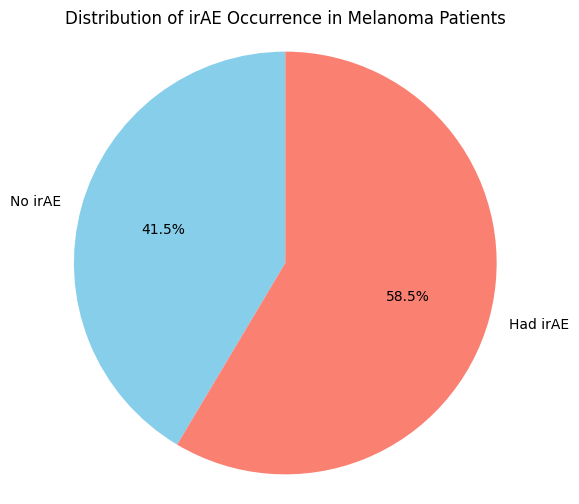

In [5466]:
create_irae_dist_plot()


### 2. No irAE Before ICI Start

In [5467]:
# Step 1: Get label from raw variable
ici_start_date_label = dict_label_lookup.get('io_dose1date')

# Step 2: Identify all 'Date of Onset' columns (including .1, .2, etc.)
date_of_onset_cols = [col for col in subset_df.columns if re.match(r'^Date of Onset(\.\d+)?$', col, re.IGNORECASE)]

# Step 3: Take row-wise minimum (ignoring NaT)
subset_df['Date of First irAE Onset'] = subset_df[date_of_onset_cols].min(axis=1)

# Filter
subset_df = subset_df[
    (subset_df['Date of First irAE Onset'].isna()) |
    (subset_df['Date of First irAE Onset'] > subset_df[ici_start_date_label])
]


criteria_vars_expanded_labels.append('Date of First irAE Onset')
subset_df.shape

(274, 200)

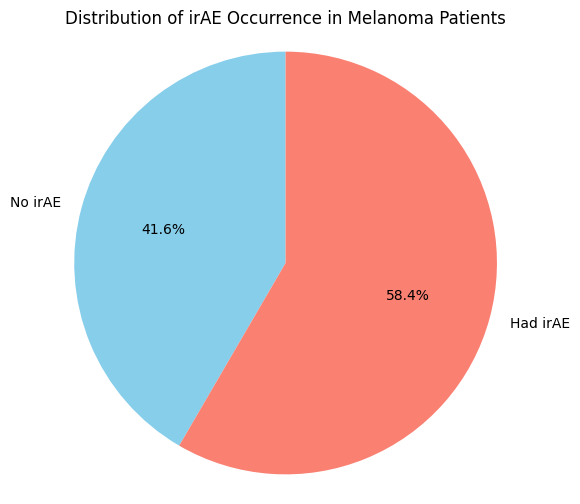

In [5468]:
create_irae_dist_plot()

### 3. At Least One Follow-up ≥ 4 Weeks After ICI Start

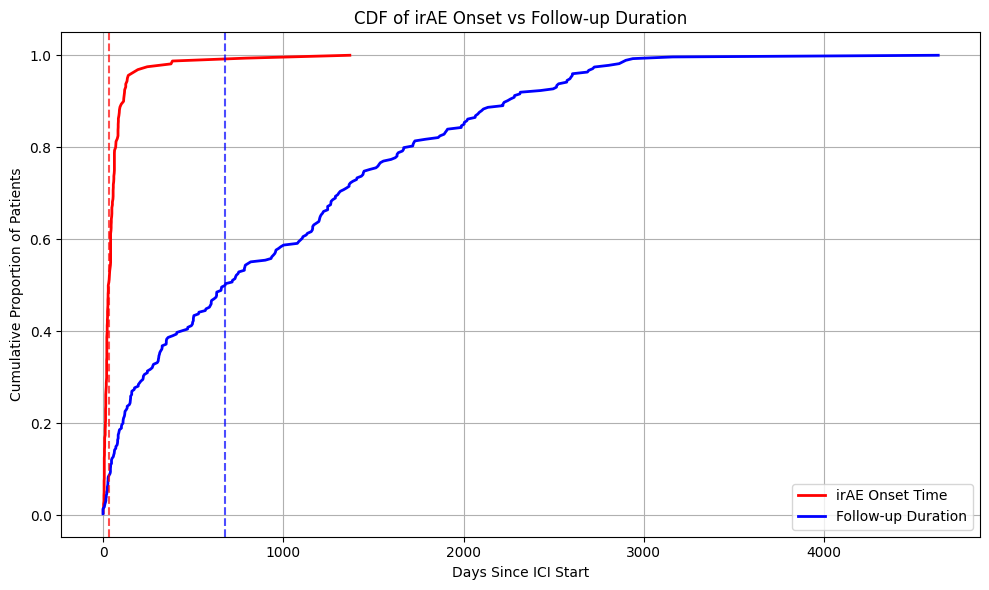

🟥 Median irAE onset time: 30.5 days
🟦 Median follow-up time: 678.0 days


In [5469]:
# === Step 1: Extract column labels from candidates lookup ===
io_dose1date_label = dict_label_lookup.get('io_dose1date')
do_followup_label = dict_label_lookup.get('do_followup')

# === Step 2: Convert date columns to datetime ===
subset_df[io_dose1date_label] = pd.to_datetime(subset_df[io_dose1date_label], errors='coerce')
subset_df[do_followup_label] = pd.to_datetime(subset_df[do_followup_label], errors='coerce')
subset_df['Date of First irAE Onset'] = pd.to_datetime(subset_df['Date of First irAE Onset'], errors='coerce')

# === Step 3: Calculate Time-to-Event Durations (in days) ===
subset_df['irae_onset_time'] = (subset_df['Date of First irAE Onset'] - subset_df[io_dose1date_label]).dt.days
subset_df['followup_time'] = (subset_df[do_followup_label] - subset_df[io_dose1date_label]).dt.days

# === Step 4: Filter out invalid or negative durations ===
irae_times = subset_df['irae_onset_time'].dropna()
irae_times = irae_times[irae_times >= 0]

followup_times = subset_df['followup_time'].dropna()
followup_times = followup_times[followup_times >= 0]

# === Step 5: Compute CDFs ===
def compute_cdf(series):
    sorted_vals = np.sort(series)
    cdf_vals = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
    return sorted_vals, cdf_vals

sorted_irae, cdf_irae = compute_cdf(irae_times)
sorted_followup, cdf_followup = compute_cdf(followup_times)

# === Step 6: Plot CDFs ===
plt.figure(figsize=(10, 6))
plt.plot(sorted_irae, cdf_irae, label='irAE Onset Time', color='red', lw=2)
plt.plot(sorted_followup, cdf_followup, label='Follow-up Duration', color='blue', lw=2)
plt.axvline(np.median(sorted_irae), color='red', linestyle='--', alpha=0.7)
plt.axvline(np.median(sorted_followup), color='blue', linestyle='--', alpha=0.7)

plt.title("CDF of irAE Onset vs Follow-up Duration")
plt.xlabel("Days Since ICI Start")
plt.ylabel("Cumulative Proportion of Patients")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 7: Print Summary Stats ===
print(f"🟥 Median irAE onset time: {np.median(sorted_irae):.1f} days")
print(f"🟦 Median follow-up time: {np.median(sorted_followup):.1f} days")


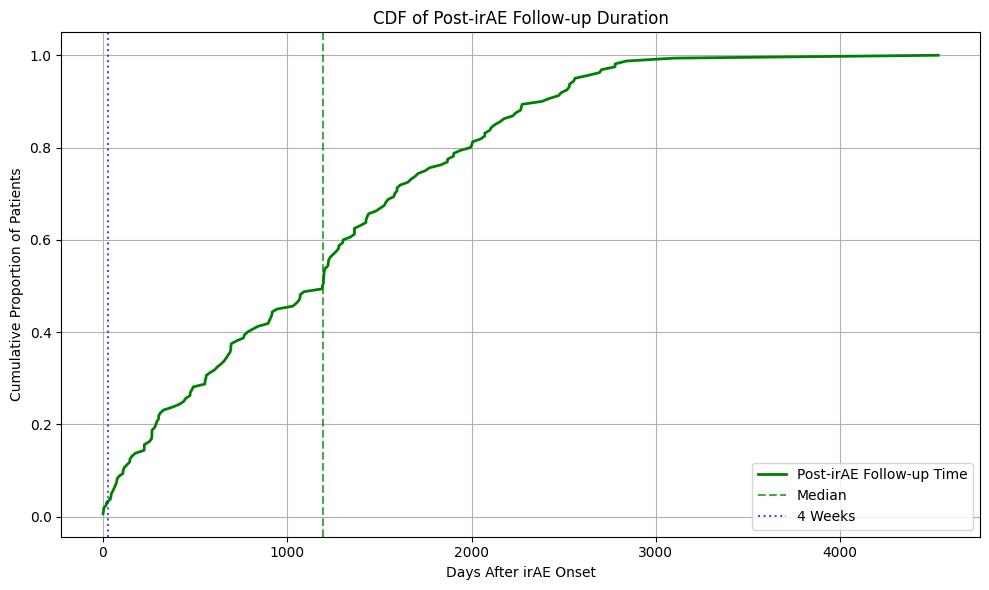

✅ Median post-irAE follow-up time: 1194.0 days


In [5470]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step 0: Load or define your subset_df and dict_label_lookup ===
# Example structure:
# subset_df = pd.read_csv('your_file.csv')
# dict_label_lookup = {'io_dose1date': 'Date of 1st ICI Dose', 'do_followup': 'Date of Last Follow-up'}

# === Step 1: Extract key date columns ===
irae_onset_col = 'Date of First irAE Onset'
followup_col = dict_label_lookup.get('do_followup')

# === Step 2: Convert relevant columns to datetime ===
subset_df[irae_onset_col] = pd.to_datetime(subset_df[irae_onset_col], errors='coerce')
subset_df[followup_col] = pd.to_datetime(subset_df[followup_col], errors='coerce')

# === Step 3: Calculate time after irAE onset ===
subset_df['post_irae_followup'] = (subset_df[followup_col] - subset_df[irae_onset_col]).dt.days

# === Step 4: Filter to valid values only (non-negative durations) ===
valid_gaps = subset_df['post_irae_followup'].dropna()
valid_gaps = valid_gaps[valid_gaps >= 0]

# === Step 5: Compute CDF ===
def compute_cdf(series):
    sorted_vals = np.sort(series)
    cdf_vals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    return sorted_vals, cdf_vals

sorted_gaps, cdf_gaps = compute_cdf(valid_gaps)

# === Step 6: Plot CDF ===
plt.figure(figsize=(10, 6))
plt.plot(sorted_gaps, cdf_gaps, color='green', lw=2, label='Post-irAE Follow-up Time')

# Add vertical line for median
plt.axvline(np.median(sorted_gaps), color='green', linestyle='--', alpha=0.7, label='Median')

# ✅ Add vertical line for 4-week mark (28 days)
plt.axvline(28, color='blue', linestyle=':', alpha=0.7, label='4 Weeks')

plt.title("CDF of Post-irAE Follow-up Duration")
plt.xlabel("Days After irAE Onset")
plt.ylabel("Cumulative Proportion of Patients")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Step 7: Print summary statistic ===
print(f"✅ Median post-irAE follow-up time: {np.median(valid_gaps):.1f} days")


In [5471]:
io_toxicity_label = dict_label_lookup.get('io_toxicity')
subset_df['irae_flag'] = (subset_df[io_toxicity_label].str.lower() == 'yes').astype(int)
# Step 1: Compute post-irAE follow-up duration
subset_df['post_irae_followup'] = (
    subset_df['followup_time'] - subset_df['irae_onset_time']
)

# Step 2: Filter out 'irae = 0' patients with < 28 days follow-up
pre_filter_n = subset_df.shape[0]

subset_df = subset_df[~(
    (subset_df['irae_flag'] == 0) & 
    (subset_df['post_irae_followup'] < 28)
)]

post_filter_n = subset_df.shape[0]
print(f"🔍 Removed {pre_filter_n - post_filter_n} patients with < 28 days follow-up and no irAE.")



🔍 Removed 0 patients with < 28 days follow-up and no irAE.


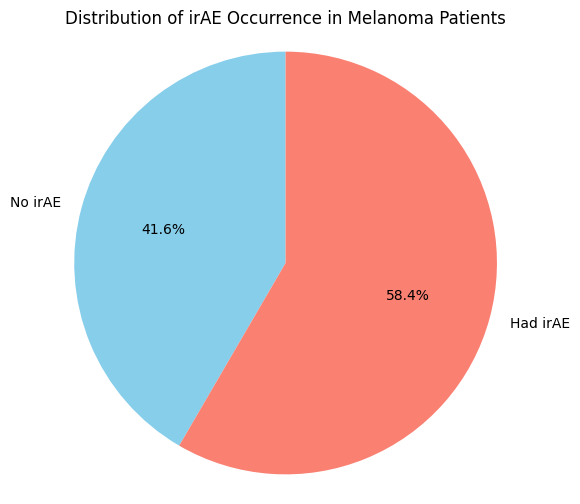

In [5472]:
create_irae_dist_plot()

In [5473]:
drop_cols = ['post_irae_followup', 'followup_time', 'irae_onset_time']
subset_df.drop(columns=drop_cols, inplace=True)


# 5. 🧮 Feature Engineering

### **ICI Drug Categories**

In [5474]:
io_drug_label = dict_label_lookup.get('io_agent1')
def get_ici_mechanism(val):
    val = str(val).lower()
    has_pd1 = 'nivolumab' in val or 'pembrolizumab' in val
    has_ctla4 = 'ipilimumab' in val

    if has_pd1 and has_ctla4:
        return 'anti-PD-1 + CTLA-4'
    elif has_pd1:
        return 'anti-PD-1'
    elif has_ctla4:
        return 'CTLA-4'
    else:
        return 'Other / Unknown'

def get_ici_combo_type(val):
    val = str(val).lower()
    if '+' in val:
        return 'combination'
    else:
        return 'monotherapy'

# Apply
subset_df['ICI Mechanism Category'] = subset_df[io_drug_label].apply(get_ici_mechanism)
subset_df['ICI Combination Type'] = subset_df[io_drug_label].apply(get_ici_combo_type)

subset_df.drop(columns=io_drug_label, inplace=True)
subset_df.shape

(274, 202)

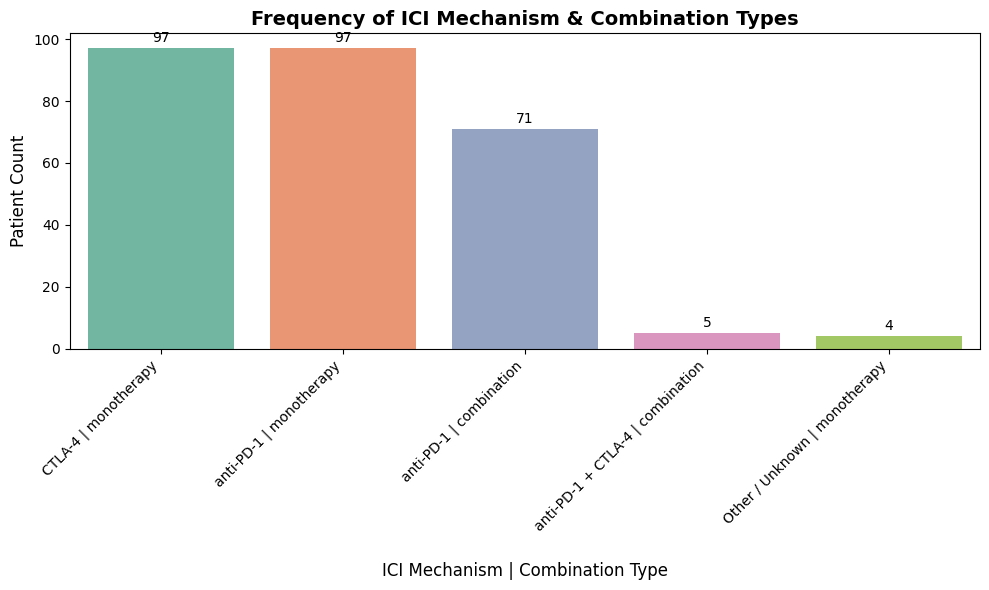

In [5475]:
# Step 1: Count combinations
cols = ['ICI Mechanism Category', 'ICI Combination Type']


# Step 1: Count combinations
combo_counts = (
    subset_df[cols]
    .value_counts()
    .reset_index()
)

# Step 2: Rename count column (regardless of pandas version)
combo_counts.columns = cols + ['Count']

# Step 3: Create label for bar x-axis
combo_counts['Combo Label'] = combo_counts[cols[0]].astype(str) + " | " + combo_counts[cols[1]].astype(str)
combo_counts = combo_counts.sort_values('Count', ascending=False)

# Step 4: Plot

plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2", n_colors=len(combo_counts))

sns.barplot(data=combo_counts, x='Combo Label', y='Count', palette=palette)
for i, row in combo_counts.iterrows():
    plt.text(i, row['Count'] + 1, row['Count'], ha='center', va='bottom')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')  # 👈 added this line

plt.xlabel('ICI Mechanism | Combination Type', labelpad=20, fontsize=12)
plt.ylabel('Patient Count', fontsize=12)
plt.title('Frequency of ICI Mechanism & Combination Types', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


### **Age**

In [5476]:
dob_label = dict_label_lookup.get('dob')
# Calculate age in years
subset_df['Age from ICI Start'] = (
    (subset_df[ici_start_date_label] - subset_df[dob_label]).dt.days / 365.25
)

subset_df.drop(columns=['Date of Birth'], inplace=True)
subset_df.shape

(274, 202)

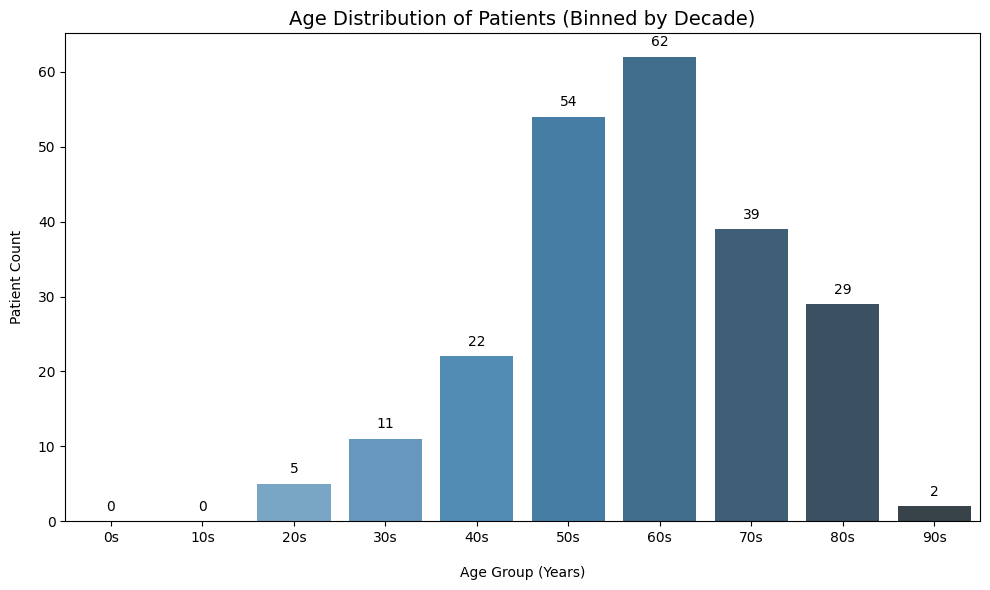

In [5477]:

# Step 0: Work with a copy
age_plot_df = subset_df.copy()

# Step 1: Create decade bins
age_plot_df['Age Group (Decade)'] = pd.cut(
    age_plot_df['Age from ICI Start'],
    bins=range(0, 110, 10),  # Adjust upper bound if needed
    right=False,
    labels=[f'{i}s' for i in range(0, 100, 10)]
)

# Step 2: Count frequencies
age_group_counts = age_plot_df['Age Group (Decade)'].value_counts().sort_index()

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='Blues_d')

# Add count labels on top of bars
for i, count in enumerate(age_group_counts.values):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

# Label formatting
plt.title('Age Distribution of Patients (Binned by Decade)', fontsize=14)
plt.xlabel('Age Group (Years)', labelpad=15)
plt.ylabel('Patient Count', labelpad=10)

plt.tight_layout()
plt.show()


### **Charslon Comorbidity Index**

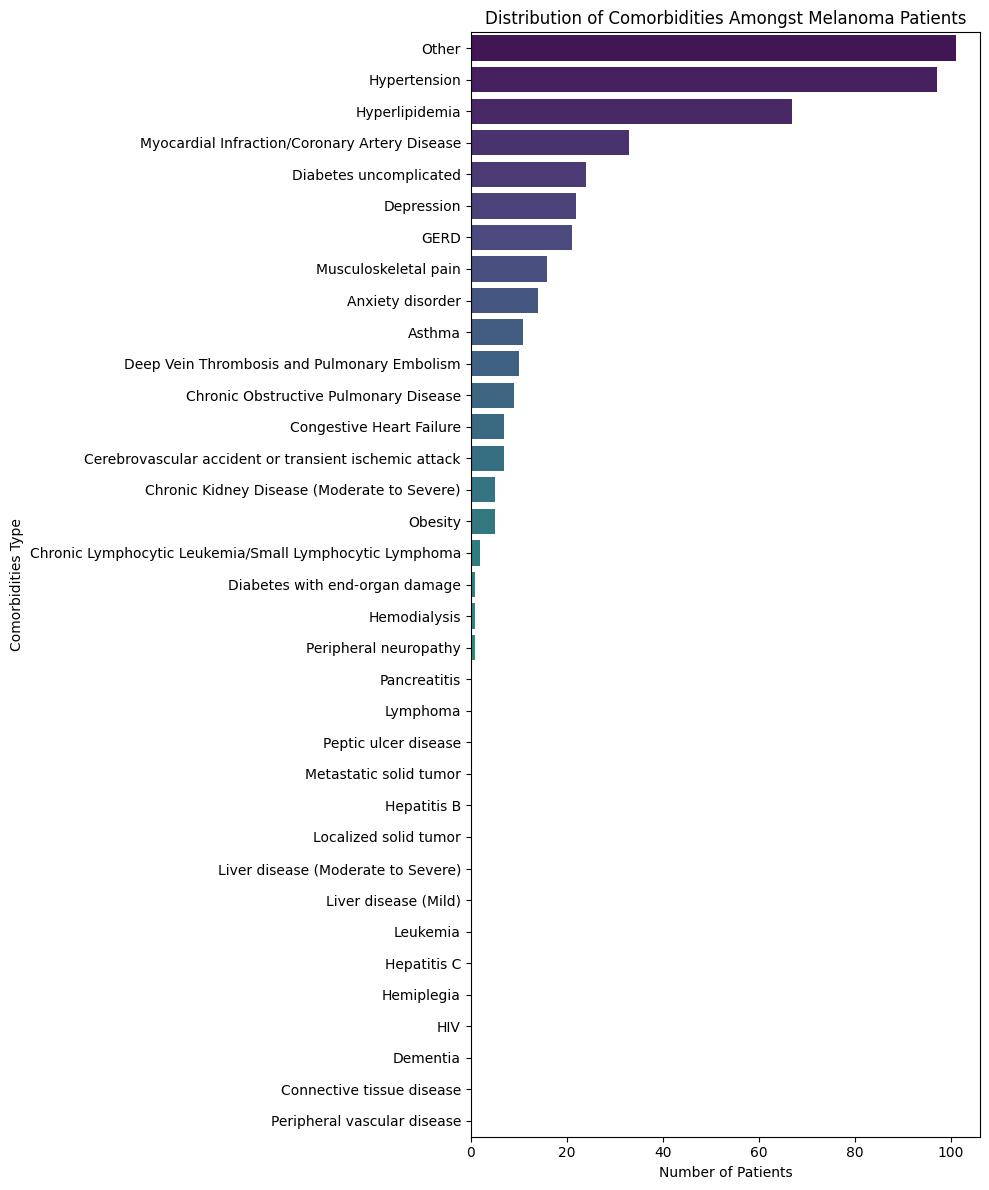

In [5478]:
# Step 2: Identify all 'Comorbidities' columns (including .1, .2, etc.)
comorbidities_cols = [col for col in subset_df.columns if re.match(r'Comorbidities', col, re.IGNORECASE)]


#🔧 2. Convert 'Checked' to 1 and 'Unchecked' to 0
subset_df[comorbidities_cols] = subset_df[comorbidities_cols].replace({'Checked': 1, 'Unchecked': 0})

# Sum across rows to get patient counts per cancer type
comorbidities_counts = subset_df[comorbidities_cols].sum().sort_values(ascending=False)

# Extract readable cancer type from column names
comorbidities_labels = comorbidities_counts.index.str.extract(r'choice=(.*)\)')[0]
comorbidities_counts.index = comorbidities_labels

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(y=comorbidities_counts.index, x=comorbidities_counts.values, palette="viridis")
plt.title("Distribution of Comorbidities Amongst Melanoma Patients")
plt.xlabel("Number of Patients")
plt.ylabel("Comorbidities Type")
plt.tight_layout()
plt.show()

In [5479]:
def get_age_score(age):
    """
    Assigns Charlson Comorbidity Index points based on age.
    """
    if pd.isnull(age):
        return 0
    if age < 50:
        return 0
    elif age < 60:
        return 1
    elif age < 70:
        return 2
    elif age < 80:
        return 3
    else:
        return 4


In [5480]:
def calculate_cci(row):
    score = 0

    # Comorbidity contributions
    score += row.get('Comorbidities (choice=Myocardial Infraction/Coronary Artery Disease)', 0) * 1
    score += row.get('Comorbidities (choice=Congestive Heart Failure)', 0) * 1
    score += row.get('Comorbidities (choice=Peripheral vascular disease)', 0) * 1
    score += row.get('Comorbidities (choice=Cerebrovascular accident or transient ischemic attack)', 0) * 1
    score += row.get('Comorbidities (choice=Dementia)', 0) * 1
    score += row.get('Comorbidities (choice=Chronic Obstructive Pulmonary Disease)', 0) * 1
    score += row.get('Comorbidities (choice=Connective tissue disease)', 0) * 1
    score += row.get('Comorbidities (choice=Peptic ulcer disease)', 0) * 1
    score += row.get('Comorbidities (choice=Liver disease (Mild))', 0) * 1
    score += row.get('Comorbidities (choice=Diabetes uncomplicated)', 0) * 1
    score += row.get('Comorbidities (choice=Diabetes with end-organ damage)', 0) * 2
    score += row.get('Comorbidities (choice=Hemiplegia)', 0) * 2
    score += row.get('Comorbidities (choice=Chronic Kidney Disease (Moderate to Severe))', 0) * 2
    score += row.get('Comorbidities (choice=Localized solid tumor)', 0) * 2
    score += row.get('Comorbidities (choice=Leukemia)', 0) * 2
    score += row.get('Comorbidities (choice=Lymphoma)', 0) * 2
    score += row.get('Comorbidities (choice=Liver disease (Moderate to Severe))', 0) * 3
    score += row.get('Comorbidities (choice=Metastatic solid tumor)', 0) * 6
    score += row.get('Comorbidities (choice=HIV)', 0) * 6

    # Age score (via helper function)
    age = row.get("Age from ICI Start", None)
    score += get_age_score(age)

    return score


In [5481]:
subset_df['Charlson Comorbidity Index'] = subset_df.apply(calculate_cci, axis=1)
subset_df.drop(columns= comorbidities_cols, inplace=True)
subset_df.shape

(274, 168)

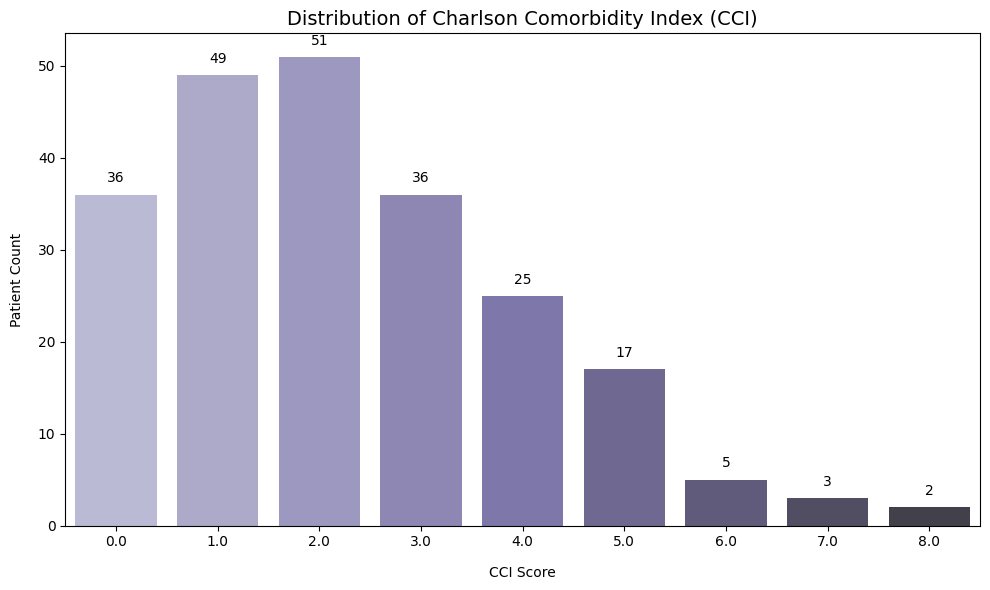

In [5482]:
# Step 0: Work on a copy
cci_plot_df = subset_df.copy()

# Step 1: Count the frequency of each CCI score
cci_counts = cci_plot_df['Charlson Comorbidity Index'].value_counts().sort_index()

# Step 2: Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=cci_counts.index.astype(str), y=cci_counts.values, palette='Purples_d')

# Add labels on top of each bar
for i, count in enumerate(cci_counts.values):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

# Label formatting
plt.title('Distribution of Charlson Comorbidity Index (CCI)', fontsize=14)
plt.xlabel('CCI Score', labelpad=12)
plt.ylabel('Patient Count', labelpad=10)

plt.tight_layout()
plt.show()


### **Cancer Grouping**

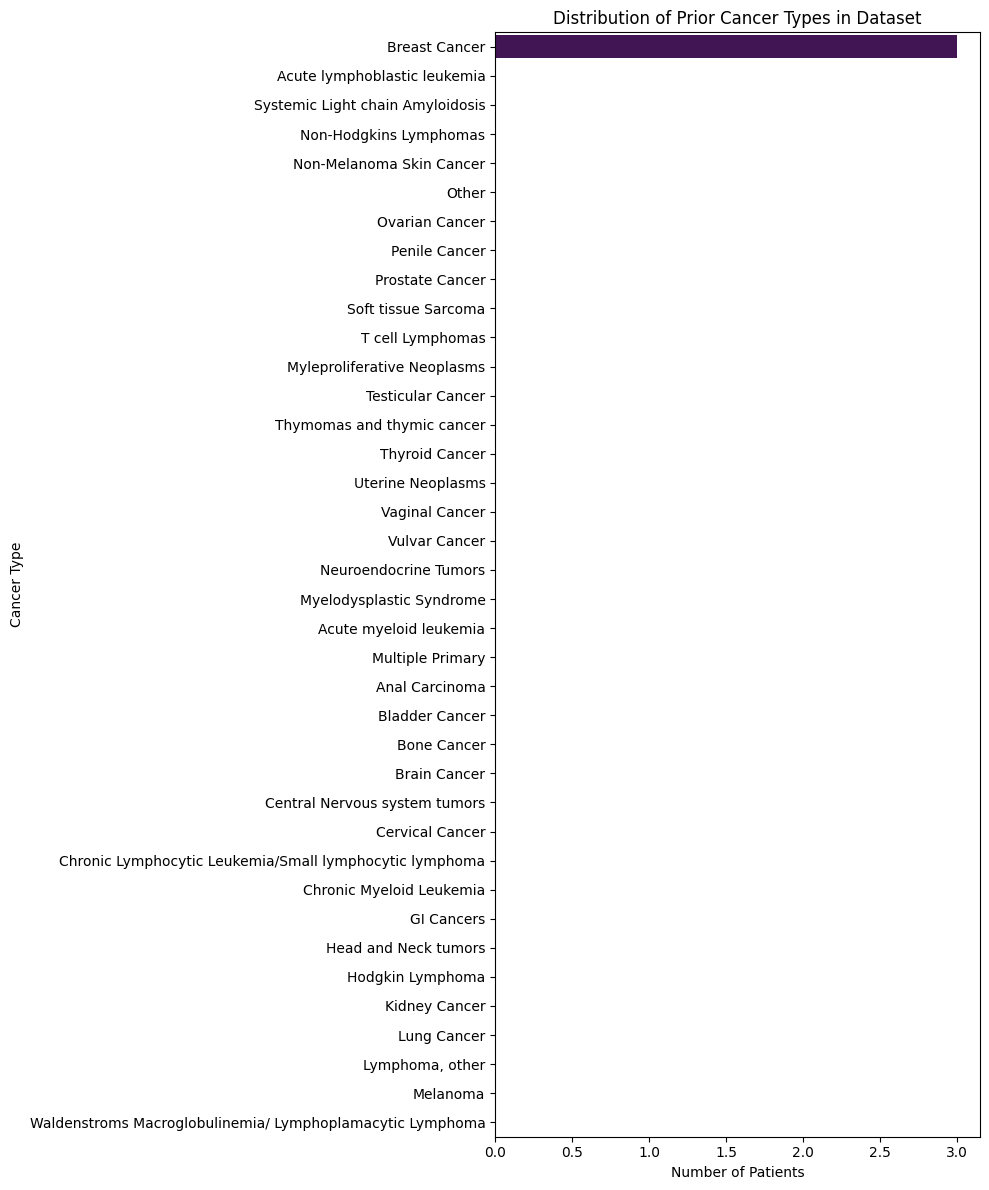

In [5483]:
# Select columns and convert to binary
cancer_history_cols = [col for col in subset_df.columns if col.startswith("Please specify what history of cancer type")]
cancer_binary_df = subset_df[cancer_history_cols].replace({'Checked': 1, 'Unchecked': 0})

# Sum across rows to get patient counts per cancer type
cancer_counts = cancer_binary_df.sum().sort_values(ascending=False)

# Extract readable cancer type from column names
cancer_labels = cancer_counts.index.str.extract(r'choice=(.*)\)')[0]
cancer_counts.index = cancer_labels

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(y=cancer_counts.index, x=cancer_counts.values, palette="viridis")
plt.title("Distribution of Prior Cancer Types in Dataset")
plt.xlabel("Number of Patients")
plt.ylabel("Cancer Type")
plt.tight_layout()
plt.show()


In [5484]:
# Create a binary column: 1 if any prior cancer history exists
subset_df.drop(columns = cancer_history_cols, inplace=True)


### **Autoimmune Grouping**

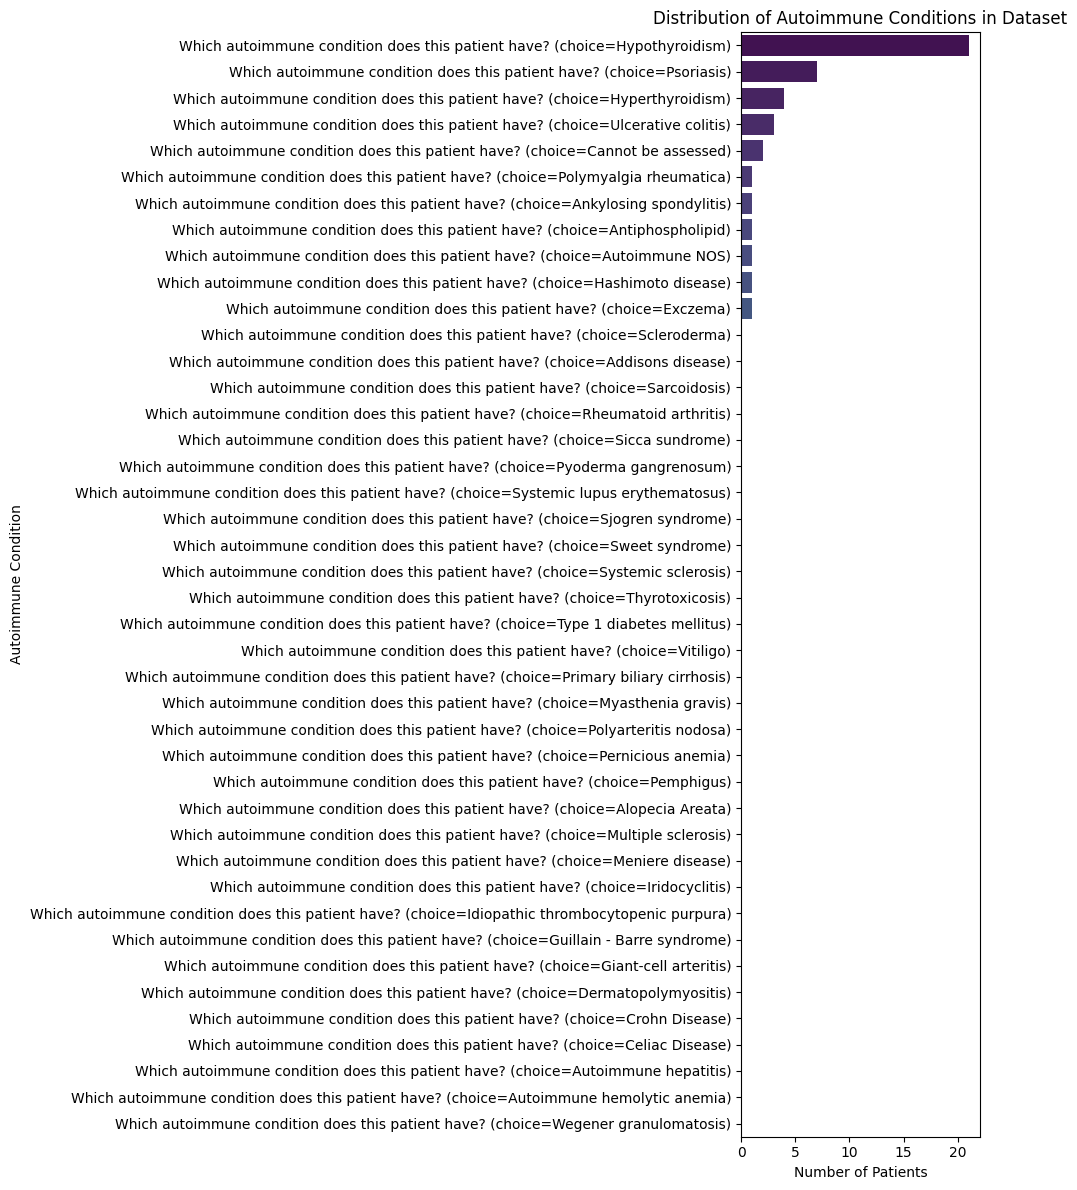

In [5485]:
# Select columns and convert to binary
autoimmune_cols = [col for col in subset_df.columns if col.startswith("Which autoimmune condition does this patient have?")]
autoimmune_binary_df = subset_df[autoimmune_cols].replace({'Checked': 1, 'Unchecked': 0})

# Sum across rows to get patient counts per autoimmune condition type
autoimmune_counts = autoimmune_binary_df.sum().sort_values(ascending=False)

# Extract readable autoimmune condition type from column names
autoimmune_labels = autoimmune_counts.index.str.extract(r'choice=(.*)\)')[0]
cancer_counts.index = cancer_labels

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(y=autoimmune_counts.index, x=autoimmune_counts.values, palette="viridis")
plt.title("Distribution of Autoimmune Conditions in Dataset")
plt.xlabel("Number of Patients")
plt.ylabel("Autoimmune Condition")
plt.tight_layout()
plt.show()


In [5486]:
# Binary flag: does patient have any autoimmune condition?
subset_df.drop(columns=autoimmune_cols, inplace=True)


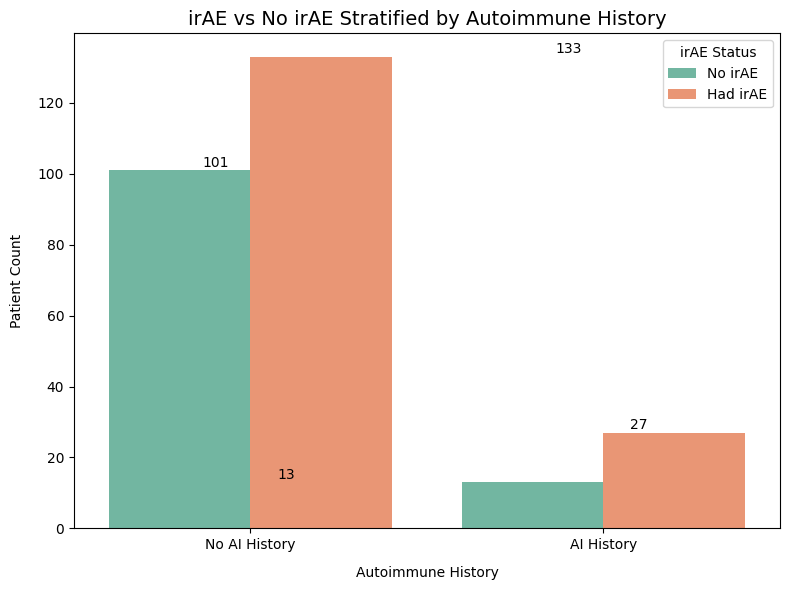

In [5487]:
# Step 0: Create a copy of the DataFrame
analysis_df = subset_df.copy()

# Step 1: Get label names
autoimmune_hx_label = dict_label_lookup.get('aid_hx')
io_toxicity_label = dict_label_lookup.get('io_toxicity')

# Step 2: Create binary irAE flag
analysis_df['irae_flag'] = (analysis_df[io_toxicity_label].str.lower() == 'yes').astype(int)

# Step 3: Create binary autoimmune history flag
analysis_df['autoimmune_flag'] = (analysis_df[autoimmune_hx_label].str.lower() == 'yes').astype(int)

# Step 4: Group and count
grouped = (
    analysis_df
    .groupby(['autoimmune_flag', 'irae_flag'])
    .size()
    .reset_index(name='count')
)

# Step 5: Relabel values for readability
grouped['Autoimmune History'] = grouped['autoimmune_flag'].map({0: 'No AI History', 1: 'AI History'})
grouped['irAE'] = grouped['irae_flag'].map({0: 'No irAE', 1: 'Had irAE'})

# Step 6: Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=grouped, x='Autoimmune History', y='count', hue='irAE', palette='Set2')

# Annotate bars
for i in range(len(grouped)):
    plt.text(
        x=i % 2 + (i // 2) * 0.2 - 0.1,
        y=grouped['count'][i] + 1,
        s=grouped['count'][i],
        ha='center'
    )

# Styling
plt.title("irAE vs No irAE Stratified by Autoimmune History", fontsize=14)
plt.xlabel("Autoimmune History", labelpad=10)
plt.ylabel("Patient Count", labelpad=10)
plt.legend(title='irAE Status')
plt.tight_layout()
plt.show()


### **Concurrent Therapy/Medication Grouping**

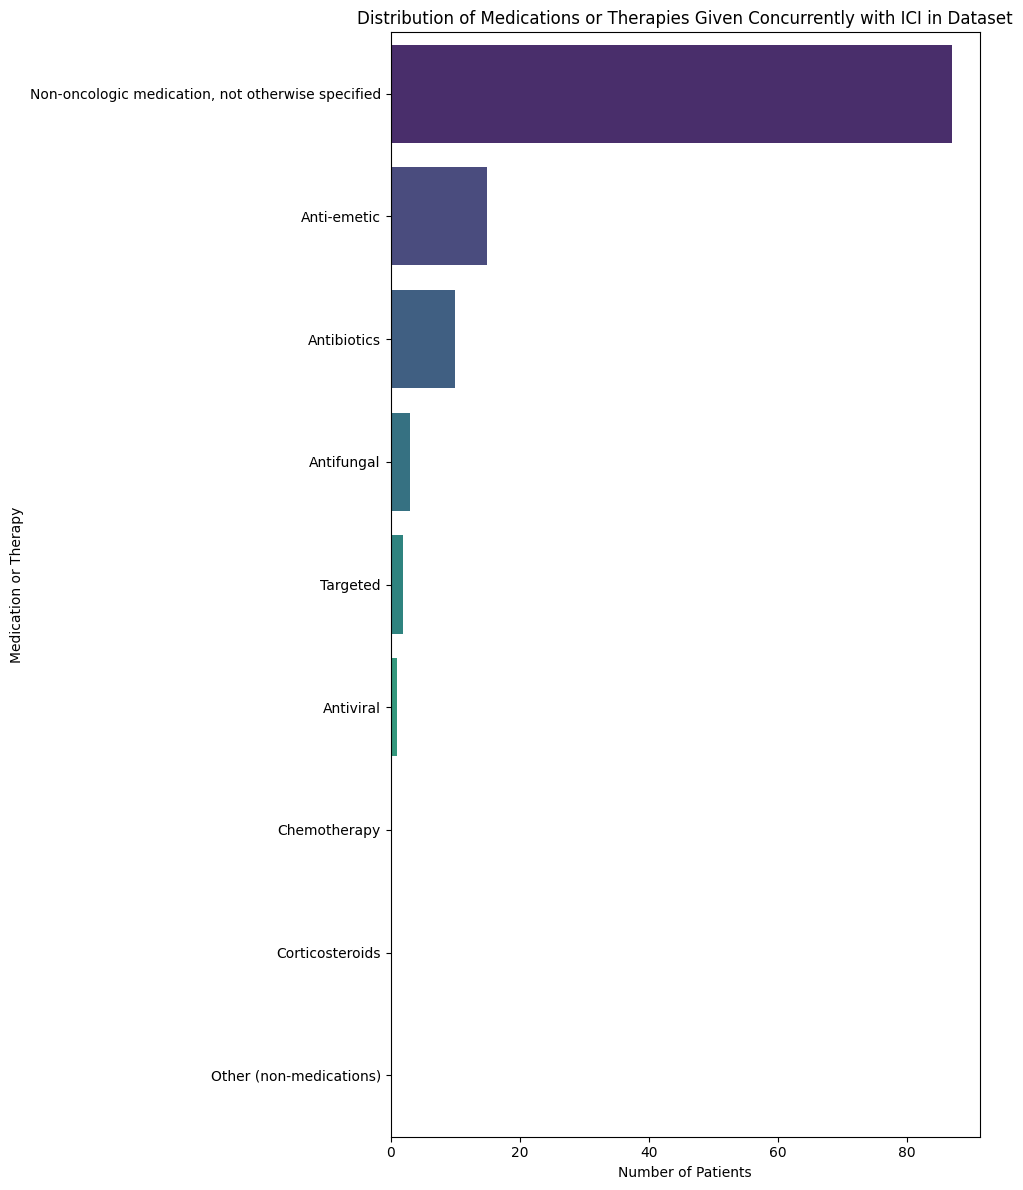

In [5488]:
# Select columns and convert to binary
conc_med_cols = [col for col in subset_df.columns if col.startswith('What therapies/medication are given concurrently with the current Immunotherapy')]
conc_med_binary_df = subset_df[conc_med_cols].replace({'Checked': 1, 'Unchecked': 0})

# Sum across rows to get patient counts per autoimmune condition type
conc_med_counts = conc_med_binary_df.sum().sort_values(ascending=False)

# Extract readable autoimmune condition type from column names
conc_med_labels = conc_med_counts.index.str.extract(r'choice=(.*)\)')[0]
conc_med_counts.index = conc_med_labels

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(y=conc_med_counts.index, x=conc_med_counts.values, palette="viridis")
plt.title("Distribution of Medications or Therapies Given Concurrently with ICI in Dataset")
plt.xlabel("Number of Patients")
plt.ylabel("Medication or Therapy")
plt.tight_layout()
plt.show()




In [5489]:
# Step 0: Create a copy to preserve original
subset_df = subset_df.copy()

# Step 1: Define column categories
antibiotic_col = 'What therapies/medication are given concurrently with the current Immunotherapy (choice=Antibiotics)'
corticosteroid_col = 'What therapies/medication are given concurrently with the current Immunotherapy (choice=Corticosteroids)'

# All columns to process
all_med_cols = [
    'What therapies/medication are given concurrently with the current Immunotherapy (choice=Anti-emetic)',
    antibiotic_col,
    'What therapies/medication are given concurrently with the current Immunotherapy (choice=Antifungal)',
    'What therapies/medication are given concurrently with the current Immunotherapy (choice=Antiviral)',
    'What therapies/medication are given concurrently with the current Immunotherapy (choice=Chemotherapy)',
    corticosteroid_col,
    'What therapies/medication are given concurrently with the current Immunotherapy (choice=Non-oncologic medication, not otherwise specified)',
    'What therapies/medication are given concurrently with the current Immunotherapy (choice=Other (non-medications))',
    'What therapies/medication are given concurrently with the current Immunotherapy (choice=Targeted)'
]

# Step 2: Convert 'Checked'/'Unchecked'/NaN → 1/0
subset_df[all_med_cols] = (
    subset_df[all_med_cols]
    .replace({'Checked': 1, 'Unchecked': 0})
    .fillna(0)
    .astype(int)
)

# Step 3: Define categories
other_cols = list(set(all_med_cols) - {antibiotic_col, corticosteroid_col})

# Step 4: Create new binary columns
subset_df['Concurrent Antibiotic'] = subset_df[antibiotic_col]
subset_df['Concurrent Corticosteroid'] = subset_df[corticosteroid_col]
subset_df['Concurrent Other Meds'] = subset_df[other_cols].sum(axis=1).clip(upper=1)

# Step 5: Handle unspecified (no meds selected at all)
subset_df['No Concurrent Meds/Unspecified'] = (
    (subset_df['Concurrent Antibiotic'] == 0) &
    (subset_df['Concurrent Corticosteroid'] == 0) &
    (subset_df['Concurrent Other Meds'] == 0)
).astype(int)

# (Optional) Drop original detailed columns if needed
subset_df.drop(columns=all_med_cols, inplace=True)

# Step 6: Review result
print(subset_df[['Concurrent Antibiotic', 'Concurrent Corticosteroid', 'Concurrent Other Meds', 'No Concurrent Meds/Unspecified']].sum())

Concurrent Antibiotic              10
Concurrent Corticosteroid           0
Concurrent Other Meds              89
No Concurrent Meds/Unspecified    184
dtype: int64


Due to the fact that there such sparsity with the Antibiotic and Corticosteroid columns, I decided to recode to 'Concurrent Meds (Any)' and 'No Concurrent Meds/Unspecified'

In [5490]:
# Combine any concurrent med types into a single column
subset_df['Concurrent Meds (Any)'] = (
    subset_df[['Concurrent Antibiotic', 'Concurrent Corticosteroid', 'Concurrent Other Meds']]
    .sum(axis=1)
    .clip(upper=1)  # Cap at 1 if multiple meds present
)

# Optional: Drop individual columns if you're not using them anymore
subset_df.drop(columns=['Concurrent Antibiotic', 'Concurrent Corticosteroid', 'Concurrent Other Meds'], inplace=True)


In [5491]:
# Final check
subset_df[['Concurrent Meds (Any)', 'No Concurrent Meds/Unspecified']].sum()

Concurrent Meds (Any)              90
No Concurrent Meds/Unspecified    184
dtype: int64

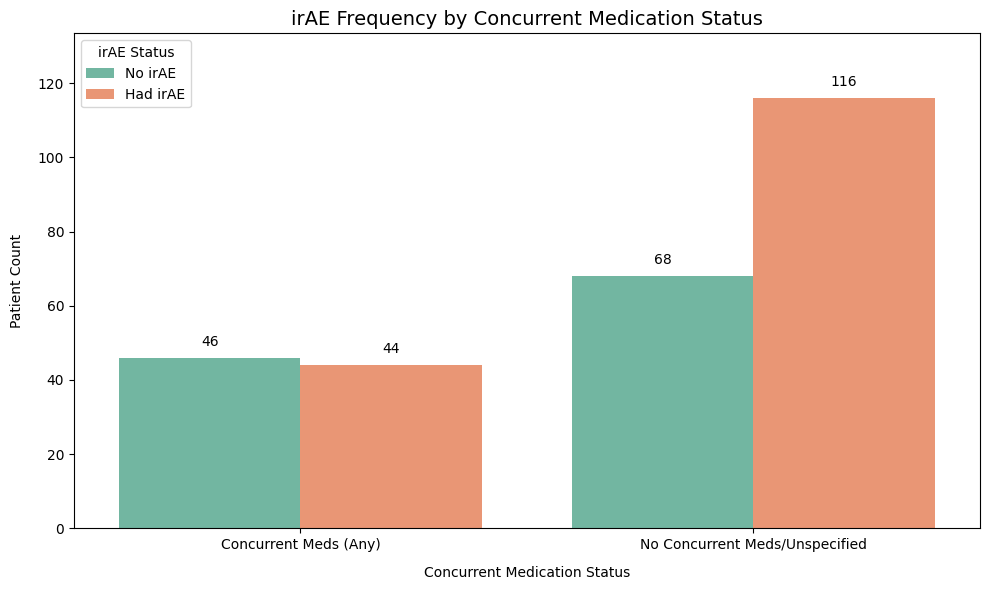

In [5492]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 0: Work on a copy
analysis_df = subset_df.copy()

# Step 1: Ensure `irae_flag` exists
io_toxicity_label = dict_label_lookup.get('io_toxicity')
analysis_df['irae_flag'] = (analysis_df[io_toxicity_label].str.lower() == 'yes').astype(int)

# Step 2: Melt into long-form to stack medication types
medication_cols = [
    'Concurrent Meds (Any)', 
    'No Concurrent Meds/Unspecified'
]

long_df = analysis_df.melt(
    id_vars='irae_flag',
    value_vars=medication_cols,
    var_name='Medication Status',
    value_name='Present'
)

# Step 3: Filter for patients who had that type of med
filtered_df = long_df[long_df['Present'] == 1]

# Step 4: Group and count
grouped = (
    filtered_df
    .groupby(['Medication Status', 'irae_flag'])
    .size()
    .reset_index(name='count')
)

# Relabel for plotting
grouped['irAE'] = grouped['irae_flag'].map({0: 'No irAE', 1: 'Had irAE'})

# Step 5: Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped, x='Medication Status', y='count', hue='irAE', palette='Set2')

# Add a little headroom
max_count = grouped['count'].max()
plt.ylim(0, max_count * 1.15)  # 15% headroom

# Annotate bars
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + max_count * 0.02,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=10
        )

# Styling
plt.title("irAE Frequency by Concurrent Medication Status", fontsize=14)
plt.xlabel("Concurrent Medication Status", labelpad=10)
plt.ylabel("Patient Count", labelpad=10)
plt.legend(title='irAE Status')
plt.tight_layout()
plt.show()


### **Metastasis Grouping**

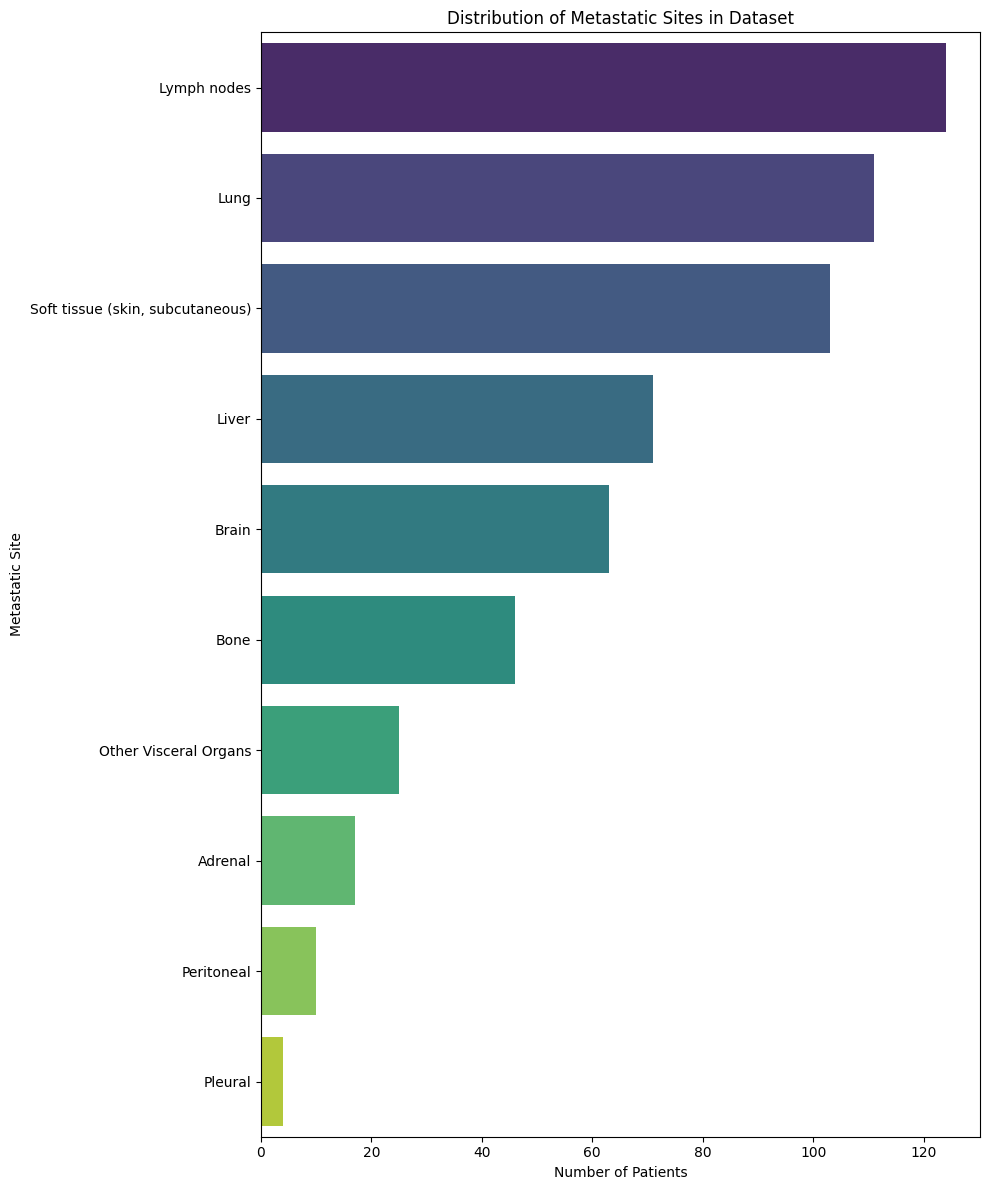

In [5493]:
# Select columns and convert to binary
metastasis_cols = [col for col in subset_df.columns if col.startswith('Metastasis') or col.startswith('Metastatic')]

metastasis_binary_df = subset_df[metastasis_cols].replace({'Checked': 1, 'Unchecked': 0})

# Sum across rows to get patient counts per metastasis location
metastasis_counts = metastasis_binary_df.sum().sort_values(ascending=False)

# Extract readable autoimmune condition type from column names
metastasis_labels = metastasis_counts.index.str.extract(r'choice=(.*)\)')[0]
metastasis_counts.index = metastasis_labels

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(y=metastasis_counts.index, x=metastasis_counts.values, palette="viridis")
plt.title("Distribution of Metastatic Sites in Dataset")
plt.xlabel("Number of Patients")
plt.ylabel("Metastatic Site")
plt.tight_layout()
plt.show()






In [5494]:
# Step 1: Get binary metastasis matrix
metastasis_cols = [col for col in subset_df.columns if col.startswith('Metastasis') or col.startswith('Metastatic')]
metastasis_binary_df = subset_df[metastasis_cols].replace({'Checked': 1, 'Unchecked': 0})

# Step 2: Drop columns that are too sparse
min_patient_threshold = 20  # Customize as needed
frequent_sites = metastasis_binary_df.columns[(metastasis_binary_df.sum() >= min_patient_threshold)]
metastasis_filtered_df = metastasis_binary_df[frequent_sites]

# Optional Step 3: Flag patients with no metastasis (if all zeros)
metastasis_filtered_df['No_Metastasis'] = (metastasis_filtered_df.sum(axis=1) == 0).astype(int)

# Add the 'No_Metastasis' column to the list of columns
new_metastasis_cols = [col for col in metastasis_filtered_df.columns if col.startswith('Metastasis')]
new_metastasis_cols.append('No_Metastasis')

metastasis_filtered_df = metastasis_filtered_df[new_metastasis_cols].replace({1:'Checked', 0: 'Unchecked'})
# Step 4: Add back into your full dataset
subset_df = pd.concat([subset_df.drop(columns=metastasis_cols, errors='ignore'),
                        metastasis_filtered_df], axis=1)



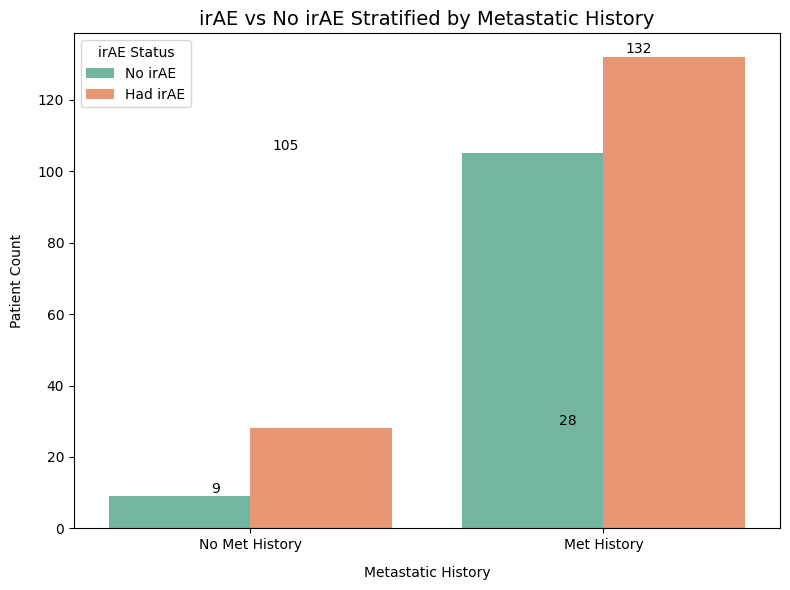

In [5495]:

# Step 0: Create a copy of the DataFrame
analysis_df = subset_df.copy()

# Step 1: Get label names
metastatic_hx_label = dict_label_lookup.get('met_iotx')
io_toxicity_label = dict_label_lookup.get('io_toxicity')

# Step 2: Create binary irAE flag
analysis_df['irae_flag'] = (analysis_df[io_toxicity_label].str.lower() == 'yes').astype(int)

# Step 3: Create binary autoimmune history flag
analysis_df['metastatic_flag'] = (analysis_df[metastatic_hx_label].str.lower() == 'yes').astype(int)

# Step 4: Group and count
grouped = (
    analysis_df
    .groupby(['metastatic_flag', 'irae_flag'])
    .size()
    .reset_index(name='count')
)

# Step 5: Relabel values for readability
grouped['Metastatic History'] = grouped['metastatic_flag'].map({0: 'No Met History', 1: 'Met History'})
grouped['irAE'] = grouped['irae_flag'].map({0: 'No irAE', 1: 'Had irAE'})

# Step 6: Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=grouped, x='Metastatic History', y='count', hue='irAE', palette='Set2')

# Annotate bars
for i in range(len(grouped)):
    plt.text(
        x=i % 2 + (i // 2) * 0.2 - 0.1,
        y=grouped['count'][i] + 1,
        s=grouped['count'][i],
        ha='center'
    )

# Styling
plt.title("irAE vs No irAE Stratified by Metastatic History", fontsize=14)
plt.xlabel("Metastatic History", labelpad=10)
plt.ylabel("Patient Count", labelpad=10)
plt.legend(title='irAE Status')
plt.tight_layout()
plt.show()


In [5496]:
metastatic_hx_label = dict_label_lookup.get('met_iotx')
subset_df.drop(columns=[metastatic_hx_label], inplace=True)

# Final Dataset

In [5497]:
included_labels = dict_df[
    (dict_df['Candidate / No Candidate'] == 'Candidate') & 
    (dict_df['Inclusion / Exclusion Criteria'] == 'Criteria')
]['Field Label'].tolist()

candidate_and_criteria_vars = [col for col in subset_df.columns if col in included_labels]
just_criteria_vars_labels = set(criteria_vars_expanded_labels) - set(candidate_and_criteria_vars)

cleaned_candidate_df = subset_df.drop(columns=just_criteria_vars_labels, inplace = False)
print(cleaned_candidate_df.shape)
cleaned_candidate_df.head()

(274, 54)


,Baseline LDH,Cancer stage at which the patient is receiving treatment,Did the patient experience any I-O toxicities?,Does the patient have unresectable disease?,Does this patient have a history of autoimmune disease?,Does this patient have previous history of cancer prior to the current cancer that IO is given for?,Dose of steroids,ECOG pre treatment,Family member #1: Cancer history,Family member #1: Please specify which cancer,...,No Concurrent Meds/Unspecified,Concurrent Meds (Any),Metastasis (choice=Bone),Metastasis (choice=Brain),Metastasis (choice=Liver),Metastasis (choice=Lung),Metastasis (choice=Lymph nodes),Metastasis (choice=Other Visceral Organs),"Metastasis (choice=Soft tissue (skin, subcutaneous))",No_Metastasis
18,NaN,IV,No,NaN,No,NaN,NaN,1.0,NaN,NaN,...,1,0,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Checked,Checked,Unchecked
20,NaN,III,Yes,Yes,No,No,NaN,0.0,NaN,NaN,...,1,0,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Checked
21,NaN,IV,Yes,NaN,Yes,No,NaN,1.0,NaN,NaN,...,0,1,Unchecked,Unchecked,Checked,Checked,Checked,Unchecked,Unchecked,Unchecked
29,NaN,IV,No,NaN,No,No,NaN,0.0,NaN,NaN,...,1,0,Unchecked,Checked,Unchecked,Checked,Checked,Unchecked,Unchecked,Unchecked
31,1319,IV,No,NaN,No,NaN,NaN,4.0,NaN,NaN,...,1,0,Unchecked,Checked,Checked,Checked,Unchecked,Unchecked,Checked,Unchecked


# 6. 📊 Variable Profiling

In [5498]:
import pandas as pd
import numpy as np
from collections import Counter

def deduplicate_columns(columns):
    counts = Counter()
    new_columns = []
    for col in columns:
        counts[col] += 1
        if counts[col] == 1:
            new_columns.append(col)
        else:
            new_columns.append(f"{col}.{counts[col] - 1}")
    return new_columns

def profile_feature_to_table(df, varname, target=None, unique_thresh=100, force_categorical_if_low_unique=True):
    # Deduplicate columns
    df = df.copy()
    df.columns = deduplicate_columns(df.columns)

    if varname not in df.columns:
        return {"Variable": varname, "Error": "Not found after deduplication"}

    series = df[varname]
    total = len(series)

    row = {
        "Variable": varname,
        "Missing (%)": round(100 * series.isna().sum() / total, 1),
        "Unique Values": int(series.nunique(dropna=False)),
        "Most Common (%)": np.nan
    }

    # Determine if we treat this as categorical
    treat_as_cat = (
        force_categorical_if_low_unique
        and series.nunique(dropna=True) <= 10
    )

    if (
        pd.api.types.is_object_dtype(series) or
        pd.api.types.is_categorical_dtype(series) or
        treat_as_cat
    ):
        non_missing_series = series.dropna()
        value_counts = non_missing_series.value_counts()
        row["Unique Values"] = int(non_missing_series.nunique())

        if not value_counts.empty:
            most_common_pct = 100 * value_counts.iloc[0] / len(non_missing_series)
            row["Most Common (%)"] = round(most_common_pct, 1)

    return row


In [5499]:
irAE_label = 'Did the patient experience any I-O toxicities?'
results = []
for col in cleaned_candidate_df.columns:
    results.append(profile_feature_to_table(cleaned_candidate_df, col, target=irAE_label))

summary_df = pd.DataFrame(results)
summary_df


,Variable,Missing (%),Unique Values,Most Common (%)
0,Baseline LDH,81.8,46,4.0
1,Cancer stage at which the patient is receiving...,0.0,12,76.3
2,Did the patient experience any I-O toxicities?,0.0,2,58.4
3,Does the patient have unresectable disease?,86.5,2,64.9
4,Does this patient have a history of autoimmune...,18.2,2,82.1
5,Does this patient have previous history of can...,84.7,2,92.9
6,Dose of steroids,100.0,0,NaN
7,ECOG pre treatment,0.4,5,49.8
8,Family member #1: Cancer history,98.5,3,50.0
9,Family member #1: Please specify which cancer,100.0,0,NaN


In [5500]:
def drop_duplicate_columns_with_suffix(df):
    """
    Detects duplicate column names (even after renaming with suffixes), 
    keeps only the first occurrence of each base name.
    """
    seen = set()
    new_columns = []
    drop_indices = []

    name_counts = {}

    for idx, col in enumerate(df.columns):
        base_col = col.split('.')[0]  # always use base name to check duplicates

        if base_col not in seen:
            seen.add(base_col)
            new_columns.append(base_col)
            name_counts[base_col] = 1
        else:
            suffix = name_counts[base_col]
            new_col_name = f"{base_col}.{suffix}"
            new_columns.append(new_col_name)
            print(f"🔄 Renaming duplicate column: {col} to {new_col_name}")
            name_counts[base_col] += 1
            drop_indices.append(idx)
            print(f"   - Duplicate occurrence at index {idx}, dropping it")

    df.columns = new_columns
    df = df.drop(columns=[df.columns[i] for i in drop_indices])
    print(f"✅ Dropped {len(drop_indices)} duplicate columns, kept {len(new_columns)} unique columns")

    return df


In [5501]:
missing_drop_cols = summary_df[summary_df['Missing (%)'] > 30]['Variable'].tolist()

cleaned_candidate_df.drop(columns=missing_drop_cols, inplace=True)
cleaned_candidate_df = drop_duplicate_columns_with_suffix(cleaned_candidate_df)
cleaned_candidate_df.shape


🔄 Renaming duplicate column: Pre treatment BMI.1 to Pre treatment BMI.1
   - Duplicate occurrence at index 6, dropping it
✅ Dropped 1 duplicate columns, kept 33 unique columns


(274, 32)

In [5502]:
sparse_drop_cols_df = summary_df[summary_df['Most Common (%)'] > 90]
sparse_drop_cols_df

,Variable,Missing (%),Unique Values,Most Common (%)
5,Does this patient have previous history of can...,84.7,2,92.9
28,Specify the subtype of melanoma (choice=Choroi...,0.0,2,97.1
30,Specify the subtype of melanoma (choice=Mucosal),0.0,2,93.8
31,Specify the subtype of melanoma (choice=Other),0.0,2,90.5
32,Specify the subtype of melanoma (choice=Uveal),0.0,2,99.6
35,Was the patient on steroids at the start of th...,0.4,2,96.0
51,Metastasis (choice=Other Visceral Organs),0.0,2,90.9


In [5503]:
drop_cols = ['Was the patient on steroids at the start of therapy?', 'irae_flag']
summary_df = summary_df[~summary_df['Variable'].isin(drop_cols)]
cleaned_candidate_df.drop(columns=drop_cols, inplace=True)
print(f"✅ Cleaned candidate DataFrame shape: {cleaned_candidate_df.shape}")

✅ Cleaned candidate DataFrame shape: (274, 30)


In [5504]:
irAE_label = 'Did the patient experience any I-O toxicities?'
results = []
for col in cleaned_candidate_df.columns:
    results.append(profile_feature_to_table(cleaned_candidate_df, col, target=irAE_label))

summary_df = pd.DataFrame(results)


In [5505]:
def style_summary(df):
    def highlight_cells(val, column_name):
        try:
            if column_name == "Missing (%)" and isinstance(val, (int, float)) and val > 30:
                return 'background-color: #f8d7da; color: #721c24;'  # red
            if column_name == "Most Common (%)" and isinstance(val, (int, float)) and val > 90:
                return 'background-color: #fff3cd; color: #856404;'  # yellow
        except:
            return ''
        return ''

    def apply_columnwise_style(s):
        return [highlight_cells(v, s.name) for v in s]

    styled = df.style \
        .apply(apply_columnwise_style, subset=["Missing (%)"]) \
        .apply(apply_columnwise_style, subset=["Most Common (%)"]) \
        .set_table_styles([
            {'selector': 'thead th',
             'props': [('background-color', '#343a40'), ('color', 'white'), ('font-weight', 'bold')]},
            {'selector': 'td',
             'props': [('padding', '8px')]},
        ]) \
        .set_caption("📋 Variable Profiling Summary")

    return styled

output_path = os.path.join(CACHE_DIR, 'variable_quality_summary.csv')
summary_df.to_csv(output_path)

# Save to HTML
styled_df = style_summary(summary_df)
output_path = os.path.join(CACHE_DIR, 'styled_variable_quality_summary.html')
styled_df.to_html(output_path, doctype_html=True)
print("✅ Fancy HTML summary saved to 'styled_variable_quality_summary.html'")


✅ Fancy HTML summary saved to 'styled_variable_quality_summary.html'


# 7. ✅ Prepare Modeling Dataset

In [5506]:
rows_with_missing = cleaned_candidate_df[cleaned_candidate_df.isna().any(axis=1)]
print(f"🧪 Rows with missing values: {len(rows_with_missing)}")


🧪 Rows with missing values: 79


In [5507]:
cleaned_candidate_df.isna().sum()


Cancer stage at which the patient is receiving treatment          0
Did the patient experience any I-O toxicities?                    0
Does this patient have a history of autoimmune disease?          50
ECOG pre treatment                                                1
Gender                                                           50
Pre treatment BMI                                                 7
Race                                                             50
Smoking History                                                  52
Specify the subtype of melanoma (choice=Choroidal)                0
Specify the subtype of melanoma (choice=Cutaneous)                0
Specify the subtype of melanoma (choice=Mucosal)                  0
Specify the subtype of melanoma (choice=Other)                    0
Specify the subtype of melanoma (choice=Uveal)                    0
Total number of metastatic sites                                 30
Was the patient previously treated with an Immun

In [5508]:
# 1. Subset rows where Gender is missing
missing_gender_df = cleaned_candidate_df[cleaned_candidate_df["Gender"].isna()]

# 2. Count missing values for each of those patients (row-wise)
missing_per_patient = missing_gender_df.isna().sum(axis=1)

# 3. Optionally, set a threshold to define "substantial missingness" (e.g., > 5 columns)
threshold = 5
patients_to_drop = missing_per_patient[missing_per_patient > threshold]

print(f"Total patients with missing gender: {len(missing_gender_df)}")
print(f"Patients with > {threshold} missing fields: {len(patients_to_drop)}")

# 4. (Optional) View those patient rows
cleaned_candidate_df.loc[patients_to_drop.index].head()

cleaned_candidate_df.drop(index=patients_to_drop.index, inplace=True)
print(f"✅ Cleaned candidate DataFrame shape after dropping: {cleaned_candidate_df.shape}")
print(cleaned_candidate_df.isna().sum())


Total patients with missing gender: 50
Patients with > 5 missing fields: 50
✅ Cleaned candidate DataFrame shape after dropping: (224, 30)
Cancer stage at which the patient is receiving treatment          0
Did the patient experience any I-O toxicities?                    0
Does this patient have a history of autoimmune disease?           0
ECOG pre treatment                                                0
Gender                                                            0
Pre treatment BMI                                                 0
Race                                                              0
Smoking History                                                   2
Specify the subtype of melanoma (choice=Choroidal)                0
Specify the subtype of melanoma (choice=Cutaneous)                0
Specify the subtype of melanoma (choice=Mucosal)                  0
Specify the subtype of melanoma (choice=Other)                    0
Specify the subtype of melanoma (choice=Uveal)

In [5509]:
cleaned_candidate_df['Pre treatment BMI'].value_counts(dropna=False)
                                                        

Pre treatment BMI
30.01    2
22.78    2
24.26    2
29.17    2
24.15    2
        ..
27.32    1
30.62    1
26.95    1
30.48    1
32.11    1
Name: count, Length: 206, dtype: int64

### Recoding Features to Handle Missingness and Avoid Sparsity

In [5510]:
# Total Number of Metastatic Sites
cleaned_candidate_df['num_met_sites'] = (
    cleaned_candidate_df['Total number of metastatic sites']
    .replace({
        '0': '1 or Less',
        '1': '1 or Less',
        '2': '2 or More/Unknown',
        '3 or more': '2 or More/Unknown'})
    .fillna('2 or More/Unknown')
)

# Treatment Line
cleaned_candidate_df['tx_line'] = (
    cleaned_candidate_df['Which line of therapy is the patient\'s current immunotherapy?']
    .replace({
        '1': 'First',
        '2': 'Second or Later/Unknown',
        '3': 'Second or Later/Unknown',
        '>=4': 'Second or Later/Unknown'})
    .fillna('Second or Later/Unknown')
)

# Charlson Comorbidity Context
median_val = cleaned_candidate_df['Charlson Comorbidity Index'].median()
cleaned_candidate_df['charlson_index'] = cleaned_candidate_df['Charlson Comorbidity Index'].fillna(median_val)

#Age
cleaned_candidate_df['age_at_ici_start'] = cleaned_candidate_df['Age from ICI Start'].fillna(cleaned_candidate_df['Age from ICI Start'].mean())

# Previously treated with Immuno-therapy
cleaned_candidate_df['prev_immunotherapy_hx'] = (
    cleaned_candidate_df['Was the patient previously treated with an Immuno-therapy?'].replace({
        'Yes': 'Yes/Unknown'})
    .fillna('Yes/Unknown'))

#Pre Treatment BMI
cleaned_candidate_df['bmi_pre_treatment'] = cleaned_candidate_df['Pre treatment BMI'].fillna(cleaned_candidate_df['Pre treatment BMI'].median())

#Gender
cleaned_candidate_df['gender'] = cleaned_candidate_df['Gender'].fillna('Unknown')

# ECOG
cleaned_candidate_df['ecog_pre_treatment'] = (
    cleaned_candidate_df['ECOG pre treatment']
    .replace({
    0.0: '0',
    1.0: '1',
    2.0: '2+/Unknown',
    3.0: '2+/Unknown',
    4.0: '2+/Unknown'})
    .fillna('2+/Unknown'))

# Autoimmune_hx
cleaned_candidate_df['autoimmune_hx'] = (
    cleaned_candidate_df['Does this patient have a history of autoimmune disease?']
    .fillna('Unknown')
)

# Race
cleaned_candidate_df['race'] = (
    cleaned_candidate_df['Race']
    .replace({
        'Other': 'Non-White',
        'Black or African America': 'Non-White',
        'Asian': 'Non-White'})
    .fillna('Not Specified/Unknown'))

# Smoking History
cleaned_candidate_df['smoking_status'] = (
    cleaned_candidate_df['Smoking History']
    .replace({
    'Never Smoked': 'Never Smoker',
    'Unknown': 'Ever Smoker/Unknown',
    'Previously Smoked, but Quit': 'Ever Smoker/Unknown',
    'Active Smoker': 'Ever Smoker/Unknown',
    'Occasional Smoking': 'Ever Smoker/Unknown'
})
    .fillna('Ever Smoker/Unknown'))


# Melanoma Subtype
melanoma_subtype_cols = {
    'Specify the subtype of melanoma (choice=Choroidal)': 'Choroidal', 
    'Specify the subtype of melanoma (choice=Cutaneous)': 'Cutaneous',
    'Specify the subtype of melanoma (choice=Mucosal)': 'Mucosal', 
    'Specify the subtype of melanoma (choice=Other)': 'Other', 
    'Specify the subtype of melanoma (choice=Uveal)': 'Uveal'
  
}

# Function to extract the subtype
def get_melanoma_subtype(row):
    for col, subtype in melanoma_subtype_cols.items():
        if row.get(col) == 'Checked':
            return subtype
        
    return 'Unspecified'

# Apply the function row-wise
cleaned_candidate_df['Melanoma Subtype'] = cleaned_candidate_df.apply(get_melanoma_subtype, axis=1)
cleaned_candidate_df['melanoma_subtype'] = cleaned_candidate_df['Melanoma Subtype'].replace({
    'Unspecified': 'Other/Unspecified',
    'Other': 'Other/Unspecified',
    'Mucosal': 'Rare Non-Cutaneous',
    'Choroidal': 'Rare Non-Cutaneous',
    'Uveal': 'Rare Non-Cutaneous',
})

# Concurrent Med Status
med_status_cols = [
    'No Concurrent Meds/Unspecified', 
    'Concurrent Meds (Any)',
]

# Function to extract the subtype
def get_med_status(row):
    for col in med_status_cols:
        if row.get(col) == 1:
            return col
    return 'Unspecified'

cleaned_candidate_df['concurrent_med_status'] = cleaned_candidate_df.apply(get_med_status, axis=1)

# ICI Mechanism
cleaned_candidate_df['ici_mechanism_category'] = cleaned_candidate_df['ICI Mechanism Category'].replace({
    'anti-PD-1 + CTLA-4': 'Other/Combo',
    'Other / Unknown': 'Other/Combo'
})

# Cancer Stage
def recode_stage(stage):
    if stage in ['IV', 'IVA', 'IVB']:
        return 'Stage IV'
    else:
        return 'Stage III or Earlier / Unknown'

cleaned_candidate_df['stage'] = cleaned_candidate_df['Cancer stage at which the patient is receiving treatment'].map(recode_stage)



### Renaming and Dropping Old Columns

In [5511]:
# Renaming Unchanged Columns
column_rename_map = {
    'Number of doses': 'num_doses',
    'Did the patient experience any I-O toxicities?': 'irae_flag',
    'ICI Combination Type': 'ici_combination_type',
    'Was metastatic disease present before IO therapy': 'metastatic_before_io',
    'Metastasis (choice=Bone)':'met_bone',
    'Metastasis (choice=Brain)':'met_brain',
    'Metastasis (choice=Liver)':'met_liver',
    'Metastasis (choice=Lung)':'met_lung',
    'Metastasis (choice=Lymph nodes)':'met_lymph',
    'Metastasis (choice=Other Visceral Organs)': 'met_vis_organs',
    'Metastasis (choice=Soft tissue (skin, subcutaneous))':'met_soft_tissue'
}

cleaned_candidate_df.rename(columns=column_rename_map, inplace=True)


# Dropping old column that were changed
old_cols = ['Race', 'Smoking History', 'Specify the subtype of melanoma (choice=Choroidal)', 'Specify the subtype of melanoma (choice=Cutaneous)',
            'Specify the subtype of melanoma (choice=Mucosal)', 'Specify the subtype of melanoma (choice=Other)', 'Specify the subtype of melanoma (choice=Uveal)',
            'No Concurrent Meds/Unspecified', 'Concurrent Meds (Any)', 'Cancer stage at which the patient is receiving treatment', 'Melanoma Subtype',
            'Does this patient have a history of autoimmune disease?', 'ECOG pre treatment', 'Gender', 'Charlson Comorbidity Index', 'Age from ICI Start', 
            'Was the patient previously treated with an Immuno-therapy?', 'Pre treatment BMI', 'ICI Mechanism Category', 'Which line of therapy is the patient\'s current immunotherapy?',
            'Total number of metastatic sites'
        ]
cleaned_candidate_df.drop(columns=old_cols, inplace=True)



# Lookup dictionary between renamed columns and the old col(s) they refer to
cleaned_candidate_df_recode_var_lookup = {
    'ecog_pre_treatment': 'ECOG pre treatment',
    'gender' : 'Gender',
    'smoking_status': 'Smoking History',
    'metastatic_before_io': 'Was metastatic disease present before IO therapy',
    'concurrent_med_status': [
        'No Concurrent Meds/Unspecified', 
        'Concurrent Meds (Any)'],
    'stage': 'Cancer stage at which the patient is receiving treatment',
    'race': 'Race',
    'num_doses': 'Number of doses',
    'bmi_pre_treatment': 'Pre treatment BMI',
    'age_at_ici_start': 'Age from ICI Start',
    'charlson_index': 'Charlson Comorbidity Index',
    'irae_flag': 'Did the patient experience any I-O toxicities?',
    'autoimmune_hx': 'Does this patient have a history of autoimmune disease?',
    'prev_immunotherapy_hx': 'Was the patient previously treated with an Immuno-therapy?',
    'melanoma_subtype': ['Specify the subtype of melanoma (choice=Choroidal)', 
        'Specify the subtype of melanoma (choice=Mucosal)', 
        'Specify the subtype of melanoma (choice=Other)', 
        'Specify the subtype of melanoma (choice=Uveal)'],
    'ici_mechanism_category': 'ICI Mechanism Category',
    'ici_combination_type': 'ICI Combination Type',
    'tx_line':'Which line of therapy is the patient\'s current immunotherapy?',
    'met_bone':'Metastasis (choice=Bone)',
    'met_brain':'Metastasis (choice=Brain)',
    'met_liver':'Metastasis (choice=Liver)',
    'met_lung':'Metastasis (choice=Lung)',
    'met_lymph':'Metastasis (choice=Lymph nodes)',
    'met_vis_organs':'Metastasis (choice=Other Visceral Organs)',
    'met_soft_tissue':'Metastasis (choice=Soft tissue (skin, subcutaneous))',
    'num_met_sites': 'Total number of metastatic sites',
    

}


# Maps Variable Names to Labels
cleaned_candidate_df_label_map= {
    'ecog_pre_treatment': 'Pretreatment ECOG',
    'gender' : 'Gender',
    'smoking_status': 'Smoking history',
    'metastatic_before_io': 'Metastatic disease present before Immuno-Oncology',
    'concurrent_med_status': 'Medications given concurrently with Immuno-Oncology',
    'stage': 'Stage',
    'race': 'Race',
    'num_doses': 'Number of therpeutic doses',
    'age_at_ici_start': 'Age--years',
    'charlson_index': 'Charlson Comorbidity Index',
    'irae_flag': 'Immune Related Adverse Event Occurence',
    'autoimmune_hx': 'History of autoimmune disease?',
    'prev_immunotherapy_hx': 'Previously treated with an Immuno-Oncology',
    'melanoma_subtype': 'Melanoma type',
    'ici_mechanism_category': 'ICI Mechanism Category',
    'ici_combination_type': 'ICI Combination Type',
    'tx_line':'Line of ICI treatment',
    'met_bone':'Metastasis of the Bone)',
    'met_brain':'Metastasis of the Brain)',
    'met_liver':'Metastasis of the Liver)',
    'met_lung':'Metastasis of the Lung)',
    'met_lymph':'Metastasis of the Lymph nodes)',
    'met_vis_organs':'Metastasis of the Visceral Organs)',
    'met_soft_tissue':'Metastasis of the Soft tissue (skin, subcutaneous))',
    'num_met_sites': 'Total number of metastatic sites',
    'bmi_pre_treatment': 'Pre treatment BMI',

}




print(cleaned_candidate_df.shape)
cleaned_candidate_df.isna().sum()


(224, 25)


irae_flag                 0
ici_combination_type      0
met_bone                  0
met_brain                 0
met_liver                 0
met_lung                  0
met_lymph                 0
met_vis_organs            0
met_soft_tissue           0
No_Metastasis             0
num_met_sites             0
tx_line                   0
charlson_index            0
age_at_ici_start          0
prev_immunotherapy_hx     0
bmi_pre_treatment         0
gender                    0
ecog_pre_treatment        0
autoimmune_hx             0
race                      0
smoking_status            0
melanoma_subtype          0
concurrent_med_status     0
ici_mechanism_category    0
stage                     0
dtype: int64

### Summary Statistic Plot

In [5512]:
# Put Categorical Columns in one list
object_cols = cleaned_candidate_df.select_dtypes(include='object').columns.tolist()
# Remove 'irae_flag' without modifying the original list in place
categorical_cols = [col for col in object_cols if col != 'irae_flag']

# Put Numeric Cols in another list 
numeric_cols = cleaned_candidate_df.select_dtypes(include='float64').columns.tolist()

# Separate Outcome Label
irae_flag_label = 'irae_flag'

In [5513]:
# 1. Split data by irAE occurrence
df_irae = cleaned_candidate_df[cleaned_candidate_df['irae_flag'] =='Yes']
df_no_irae = cleaned_candidate_df[cleaned_candidate_df['irae_flag'] == 'No']

# 2. Function to summarize categorical features
def summarize_categorical(col):
    overall_counts = cleaned_candidate_df[col].value_counts(dropna=False)
    irae_counts = df_irae[col].value_counts(dropna=False)
    no_irae_counts = df_no_irae[col].value_counts(dropna=False)
    
    summary_rows = []

    # Header row for the variable
    summary_rows.append({
        "Feature": f"{cleaned_candidate_df_label_map.get(col)}",  # No equals sign
        "Overall N (%)": "",
        "irAE N (%)": "",
        "No irAE N (%)": ""
    })

    # Now add indented levels
    for level in overall_counts.index:
        display_level = f"    {level}"  # 4 spaces for indentation
        row = {
            "Feature": display_level,
            "Overall N (%)": f"{overall_counts[level]} ({overall_counts[level] / len(cleaned_candidate_df) * 100:.2f})",
            "irAE N (%)": f"{irae_counts.get(level, 0)} ({irae_counts.get(level, 0) / len(df_irae) * 100:.2f})",
            "No irAE N (%)": f"{no_irae_counts.get(level, 0)} ({no_irae_counts.get(level, 0) / len(df_no_irae) * 100:.2f})",
        }
        summary_rows.append(row)
    
    return summary_rows

# 3. Function to summarize numeric features
def summarize_numeric(col):
    row = {
        "Feature": f"{cleaned_candidate_df_label_map.get(col)}, mean (SD)",
        "Overall N (%)": f"{cleaned_candidate_df[col].mean():.2f} ({cleaned_candidate_df[col].std():.2f})",
        "irAE N (%)": f"{df_irae[col].mean():.2f} ({df_irae[col].std():.2f})",
        "No irAE N (%)": f"{df_no_irae[col].mean():.2f} ({df_no_irae[col].std():.2f})",
    }
    return [row]

# 4. Define your features
categorical_cols
numeric_cols

# 5. Build summary table
summary = []

for col in numeric_cols:
    summary.extend(summarize_numeric(col))

for col in categorical_cols:
    summary.extend(summarize_categorical(col))

# 6. Convert to DataFrame
summary_df = pd.DataFrame(summary)

# 7. Rename columns to match clinical paper style
n_all = len(cleaned_candidate_df)
n_irae = len(df_irae)
n_no_irae = len(df_no_irae)

summary_df.columns = [
    "Characteristic, no. (%)",
    f"Entire cohort\nN = {n_all}",
    f"irAE\nN = {n_irae}",
    f"No irAE\nN = {n_no_irae}"
]

# 8. Display the table title and DataFrame
print("Table 1. Patient characteristics categorized by irAE occurrence.\n")
display(summary_df)


# Export to Excel
excel_filename = "irAE_summary_table.xlsx"
output_path = os.path.join(CACHE_DIR, excel_filename)
summary_df.to_excel(output_path, index=False)




Table 1. Patient characteristics categorized by irAE occurrence.



,"Characteristic, no. (%)",Entire cohort\nN = 224,irAE\nN = 138,No irAE\nN = 86
0,"Charlson Comorbidity Index, mean (SD)",2.28 (1.76),2.02 (1.54),2.70 (2.01)
1,"Age--years, mean (SD)",62.87 (14.67),60.93 (13.77),65.98 (15.60)
2,"Pre treatment BMI, mean (SD)",27.83 (5.84),27.84 (5.00),27.81 (7.00)
3,ICI Combination Type,,,
4,monotherapy,155 (69.20),77 (55.80),78 (90.70)
...,...,...,...,...
65,CTLA-4,93 (41.52),53 (38.41),40 (46.51)
66,Other/Combo,5 (2.23),5 (3.62),0 (0.00)
67,Stage,,,
68,Stage IV,171 (76.34),104 (75.36),67 (77.91)


In [5514]:
cleaned_candidate_df.dtypes

irae_flag                  object
ici_combination_type       object
met_bone                   object
met_brain                  object
met_liver                  object
met_lung                   object
met_lymph                  object
met_vis_organs             object
met_soft_tissue            object
No_Metastasis              object
num_met_sites              object
tx_line                    object
charlson_index            float64
age_at_ici_start          float64
prev_immunotherapy_hx      object
bmi_pre_treatment         float64
gender                     object
ecog_pre_treatment         object
autoimmune_hx              object
race                       object
smoking_status             object
melanoma_subtype           object
concurrent_med_status      object
ici_mechanism_category     object
stage                      object
dtype: object

# 8. Model Training

## Feature Normalization and Train/Test Split


In [5515]:
cleaned_candidate_df.columns

Index(['irae_flag', 'ici_combination_type', 'met_bone', 'met_brain',
       'met_liver', 'met_lung', 'met_lymph', 'met_vis_organs',
       'met_soft_tissue', 'No_Metastasis', 'num_met_sites', 'tx_line',
       'charlson_index', 'age_at_ici_start', 'prev_immunotherapy_hx',
       'bmi_pre_treatment', 'gender', 'ecog_pre_treatment', 'autoimmune_hx',
       'race', 'smoking_status', 'melanoma_subtype', 'concurrent_med_status',
       'ici_mechanism_category', 'stage'],
      dtype='object')

In [5516]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# Step 0: Work on a copy
df = cleaned_candidate_df.copy()

# Step 1: One-hot encode categorical columns (binary 0/1)
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
print(df_encoded.columns)
non_drop_cols = ['irae_flag', 'charlson_index', 'age_at_ici_start',
             'ici_combination_type_monotherapy',  'bmi_pre_treatment',
       'met_bone_Checked', 'met_brain_Checked', 'met_liver_Checked',
       'met_lung_Checked', 'met_lymph_Checked', 'met_vis_organs_Checked', 
       'met_soft_tissue_Checked', 'No_Metastasis_Checked', 'num_met_sites_1 or Less',
       'tx_line_First', 'prev_immunotherapy_hx_Yes/Unknown', 'gender_Male', 'ecog_pre_treatment_1',
       'ecog_pre_treatment_2+/Unknown', 'autoimmune_hx_Yes', 'race_Not Specified/Unknown',
       'race_White', 'smoking_status_Ever Smoker/Unknown', 'melanoma_subtype_Cutaneous',
       'melanoma_subtype_Other/Unspecified', 'concurrent_med_status_Concurrent Meds (Any)',
       'ici_mechanism_category_CTLA-4', 'ici_mechanism_category_anti-PD-1', 'stage_Stage IV']
drop_cols = [col for col in df_encoded.columns if col not in non_drop_cols]
df_encoded.drop(columns=drop_cols, inplace=True)

# Step 2: Extract target before scaling
y = df_encoded['irae_flag'].map({'Yes': 1, 'No': 0})
X = df_encoded.drop(columns=['irae_flag'])

# Step 3: Standard scale all features (numerical + one-hot)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)


Index(['irae_flag', 'charlson_index', 'age_at_ici_start', 'bmi_pre_treatment',
       'ici_combination_type_combination', 'ici_combination_type_monotherapy',
       'met_bone_Checked', 'met_bone_Unchecked', 'met_brain_Checked',
       'met_brain_Unchecked', 'met_liver_Checked', 'met_liver_Unchecked',
       'met_lung_Checked', 'met_lung_Unchecked', 'met_lymph_Checked',
       'met_lymph_Unchecked', 'met_vis_organs_Checked',
       'met_vis_organs_Unchecked', 'met_soft_tissue_Checked',
       'met_soft_tissue_Unchecked', 'No_Metastasis_Checked',
       'No_Metastasis_Unchecked', 'num_met_sites_1 or Less',
       'num_met_sites_2 or More/Unknown', 'tx_line_First',
       'tx_line_Second or Later/Unknown', 'prev_immunotherapy_hx_No',
       'prev_immunotherapy_hx_Yes/Unknown', 'gender_Female', 'gender_Male',
       'ecog_pre_treatment_0', 'ecog_pre_treatment_1',
       'ecog_pre_treatment_2+/Unknown', 'autoimmune_hx_No',
       'autoimmune_hx_Yes', 'race_Non-White', 'race_Not Specified/Un

In [5517]:
from collections import Counter
import numpy as np

# Count occurrences in training set
train_counts = Counter(y_train)
train_total = sum(train_counts.values())
train_balance = {k: f"{v} ({v/train_total:.2%})" for k, v in train_counts.items()}

# Count occurrences in testing set
test_counts = Counter(y_test)
test_total = sum(test_counts.values())
test_balance = {k: f"{v} ({v/test_total:.2%})" for k, v in test_counts.items()}

# Display
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print("🔍 Class Distribution in Training Set:")
for cls, val in train_balance.items():
    print(f"  Class {cls}: {val}")

print("\n🔍 Class Distribution in Testing Set:")
for cls, val in test_balance.items():
    print(f"  Class {cls}: {val}")


Training set shape: (156, 28)
Testing set shape: (68, 28)
🔍 Class Distribution in Training Set:
  Class 0: 60 (38.46%)
  Class 1: 96 (61.54%)

🔍 Class Distribution in Testing Set:
  Class 1: 42 (61.76%)
  Class 0: 26 (38.24%)


In [5518]:
X.columns

Index(['charlson_index', 'age_at_ici_start', 'bmi_pre_treatment',
       'ici_combination_type_monotherapy', 'met_bone_Checked',
       'met_brain_Checked', 'met_liver_Checked', 'met_lung_Checked',
       'met_lymph_Checked', 'met_vis_organs_Checked',
       'met_soft_tissue_Checked', 'No_Metastasis_Checked',
       'num_met_sites_1 or Less', 'tx_line_First',
       'prev_immunotherapy_hx_Yes/Unknown', 'gender_Male',
       'ecog_pre_treatment_1', 'ecog_pre_treatment_2+/Unknown',
       'autoimmune_hx_Yes', 'race_Not Specified/Unknown', 'race_White',
       'smoking_status_Ever Smoker/Unknown', 'melanoma_subtype_Cutaneous',
       'melanoma_subtype_Other/Unspecified',
       'concurrent_med_status_Concurrent Meds (Any)',
       'ici_mechanism_category_CTLA-4', 'ici_mechanism_category_anti-PD-1',
       'stage_Stage IV'],
      dtype='object')

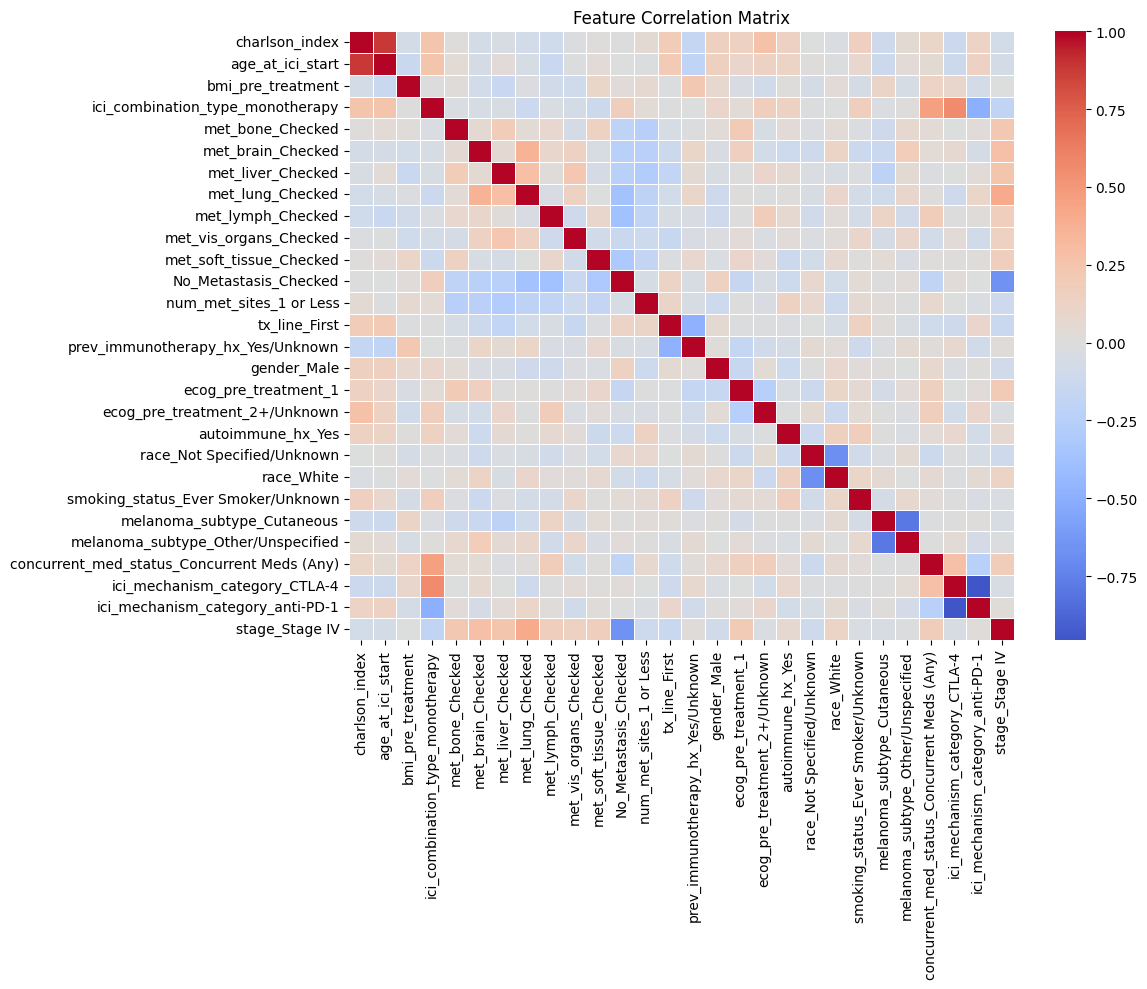

In [5519]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume X is your feature matrix (pandas DataFrame)
# If your data isn't already in a DataFrame, convert it:
# X = pd.DataFrame(X, columns=feature_names)

# 1. Compute correlation matrix
corr_matrix = X.corr()

# 2. Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Model Training and Performance Plots

In [5520]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ✅ Updated feature groups using new column names
feature_groups = {
    'demographics': [
        'age_at_ici_start',
        'gender_Male',
        'race_Not Specified/Unknown',
        'race_White'
    ],
    'comorbidity': ['charlson_index'],
    'lifestyle': [
        'bmi_pre_treatment',
        'smoking_status_Ever Smoker/Unknown'
    ],
    'ecog_status': [
        'ecog_pre_treatment_1',
        'ecog_pre_treatment_2+/Unknown'
    ],
    'autoimmune': ['autoimmune_hx_Yes'],
    'treatment_history': [
        'tx_line_First',
        'prev_immunotherapy_hx_Yes/Unknown'
    ],
    'treatment_type': [
        'ici_combination_type_monotherapy',
        'concurrent_med_status_Concurrent Meds (Any)',
        'ici_mechanism_category_CTLA-4',
        'ici_mechanism_category_anti-PD-1'
    ],
    'melanoma_subtype': [
        'melanoma_subtype_Cutaneous',
        'melanoma_subtype_Other/Unspecified'
    ],
    'metastasis': [
        'num_met_sites_1 or Less',
        'met_bone_Checked',
        'met_brain_Checked',
        'met_liver_Checked',
        'met_lung_Checked',
        'met_lymph_Checked',
        'met_vis_organs_Checked',
        'met_soft_tissue_Checked',
        'No_Metastasis_Checked'
    ],
    'stage': ['stage_Stage IV']
}


# Evaluate each group individually using 3-fold cross-validated AUROC
group_scores = {}
for name, cols in feature_groups.items():
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, random_state=42)
    )
    scores = cross_val_score(pipeline, X_train[cols], y_train, cv=3, scoring='roc_auc')
    group_scores[name] = scores.mean()

# Convert to DataFrame and sort
group_auc_df = pd.DataFrame(group_scores.items(), columns=["Feature Group", "Mean AUROC"])
group_auc_df = group_auc_df.sort_values("Mean AUROC", ascending=False)

# Print the result
print(group_auc_df)



       Feature Group  Mean AUROC
6     treatment_type    0.741667
0       demographics    0.691146
3        ecog_status    0.681510
1        comorbidity    0.625521
2          lifestyle    0.590104
8         metastasis    0.518229
7   melanoma_subtype    0.493490
4         autoimmune    0.485417
9              stage    0.459375
5  treatment_history    0.453125


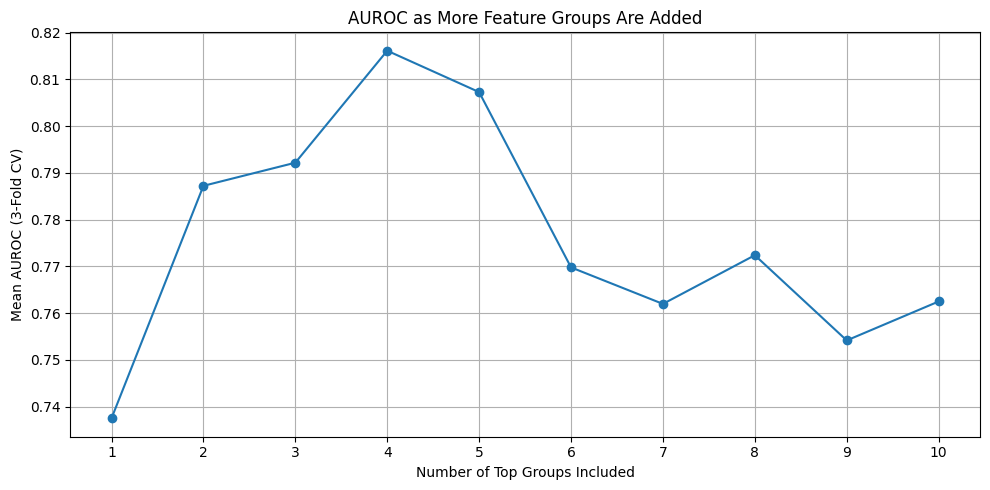

In [5521]:

# Order by previous results (from best to worst AUROC)
group_order = ['treatment_type', 'ecog_status', 'lifestyle', 'demographics', 'comorbidity',
               'metastasis', 'melanoma_subtype', 'autoimmune', 'treatment_history', 'stage']

# Loop through cumulative groups
results = []
included_features = []

for i in range(1, len(group_order)+1):
    # Add features from top i groups
    current_groups = group_order[:i]
    current_features = sum([feature_groups[g] for g in current_groups], [])

    # Train and score
    model = LogisticRegression(max_iter=1000, random_state=42)
    scores = cross_val_score(model, X_train[current_features], y_train, cv=3, scoring='roc_auc')
    mean_auc = np.mean(scores)

    results.append({
        "Top N Groups": i,
        "Included": current_groups,
        "AUROC": mean_auc
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(results_df["Top N Groups"], results_df["AUROC"], marker='o')
plt.title("AUROC as More Feature Groups Are Added")
plt.xlabel("Number of Top Groups Included")
plt.ylabel("Mean AUROC (3-Fold CV)")
plt.xticks(results_df["Top N Groups"])
plt.grid(True)
plt.tight_layout()
plt.show()

# Show results
display(name="Cumulative Feature Group Results", dataframe=results_df)


['ici_combination_type_monotherapy', 'concurrent_med_status_Concurrent Meds (Any)', 'ici_mechanism_category_CTLA-4', 'ici_mechanism_category_anti-PD-1', 'ecog_pre_treatment_1', 'ecog_pre_treatment_2+/Unknown', 'bmi_pre_treatment', 'smoking_status_Ever Smoker/Unknown', 'autoimmune_hx_Yes']


Tuning models:   0%|          | 0/7 [00:00<?, ?it/s]


🔍 Tuning LR...
✅ Best Parameters for LR:
   • C: 0.1
   • penalty: l2
   • solver: lbfgs

🔍 Tuning RF...


Tuning models:  29%|██▊       | 2/7 [00:00<00:00,  8.80it/s]

✅ Best Parameters for RF:
   • class_weight: balanced
   • max_depth: 3
   • min_samples_leaf: 4
   • min_samples_split: 10
   • n_estimators: 50

🔍 Tuning GB...


Tuning models:  43%|████▎     | 3/7 [00:00<00:00,  7.16it/s]

✅ Best Parameters for GB:
   • learning_rate: 0.05
   • max_depth: 3
   • n_estimators: 50

🔍 Tuning XGB...


Tuning models: 100%|██████████| 7/7 [00:00<00:00, 11.77it/s]

✅ Best Parameters for XGB:
   • learning_rate: 0.05
   • max_depth: 5
   • n_estimators: 50

🔍 Tuning SVM...
✅ Best Parameters for SVM:
   • svc__C: 0.1
   • svc__gamma: scale
   • svc__kernel: rbf

🔍 Tuning KNN...
✅ Best Parameters for KNN:
   • kneighborsclassifier__n_neighbors: 5
   • kneighborsclassifier__weights: uniform

🔍 Tuning BNB...
✅ Best Parameters for BNB:
   • alpha: 1.0
   • binarize: 0.0


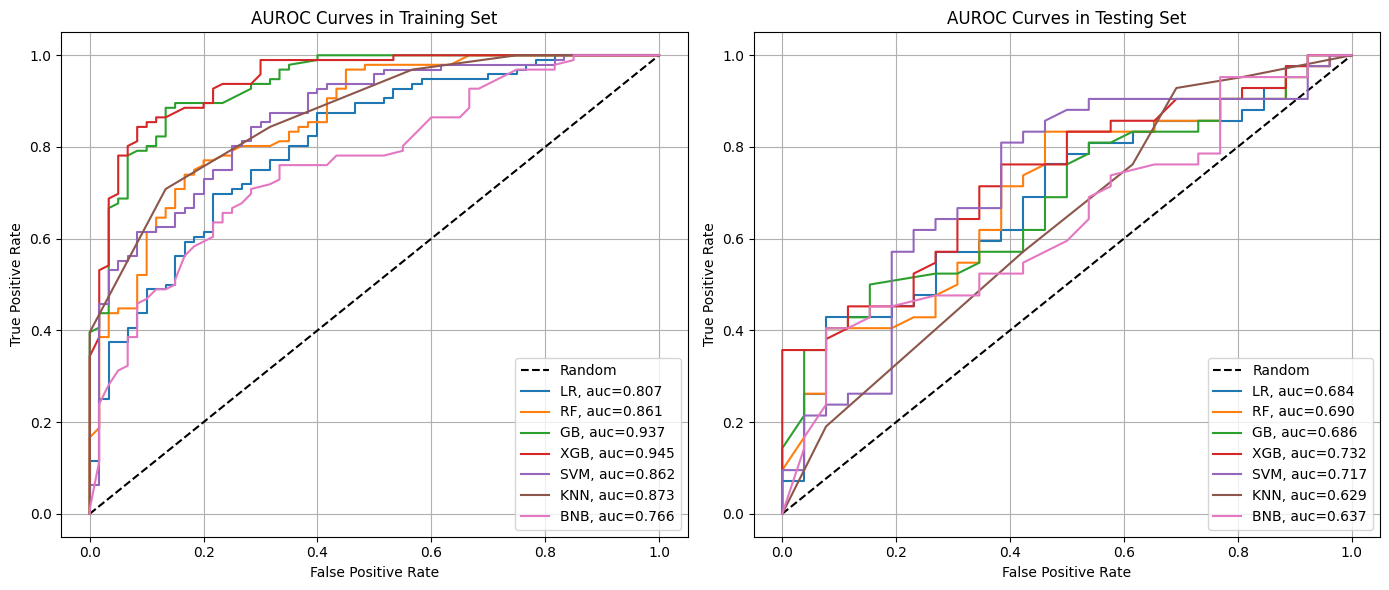

In [5522]:
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

# ✅ Use only top 2 groups
top_groups = ['treatment_type', 'ecog_status','lifestyle','autoimmune']
top_features = sum([feature_groups[g] for g in top_groups], [])
print(top_features)
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# ✅ Define models and param grids
models_and_grids = {
    'LR': (
        LogisticRegression(max_iter=1000, random_state=42),
        {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']}
    ),
    'RF': (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [25, 50],
            'max_depth': [3, 5],
            'min_samples_split': [10],
            'min_samples_leaf': [4],
            'class_weight': ['balanced']
        }
    ),
    'GB': (
        GradientBoostingClassifier(random_state=42),
        {
            'n_estimators': [25, 50],
            'learning_rate': [0.01, 0.05],
            'max_depth': [3, 5]
        }
    ),
    'XGB': (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        {
            'n_estimators': [25, 50],
            'learning_rate': [0.01, 0.05],
            'max_depth': [3, 5]
        }
    ),
    'SVM': (
        make_pipeline(StandardScaler(), SVC(probability=True)),
        {
            'svc__C': [0.1, 1],
            'svc__gamma': ['scale'],
            'svc__kernel': ['rbf']
        }
    ),
    'KNN': (
        make_pipeline(StandardScaler(), KNeighborsClassifier()),
        {
            'kneighborsclassifier__n_neighbors': [3, 5],
            'kneighborsclassifier__weights': ['uniform']
        }
    ),
    'BNB': (
        BernoulliNB(),
        {
            'alpha': [0.1, 1.0],
            'binarize': [0.0]
        }
    )
}

# ✅ Setup AUROC plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title("AUROC Curves in Training Set")
axes[1].set_title("AUROC Curves in Testing Set")
for ax in axes:
    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.grid(True)

best_models = {}

# ✅ Loop through models
for name, (model, param_grid) in tqdm(models_and_grids.items(), desc="Tuning models", total=len(models_and_grids)):
    print(f"\n🔍 Tuning {name}...")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )

    grid.fit(X_train_top, y_train)
    best_model = grid.best_estimator_
    best_models[name] = best_model

    print(f"✅ Best Parameters for {name}:")
    for param, val in grid.best_params_.items():
        print(f"   • {param}: {val}")

    # AUROC for train
    y_train_proba = best_model.predict_proba(X_train_top)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    auc_train = roc_auc_score(y_train, y_train_proba)
    axes[0].plot(fpr_train, tpr_train, label=f"{name}, auc={auc_train:.3f}")

    # AUROC for test
    y_test_proba = best_model.predict_proba(X_test_top)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    auc_test = roc_auc_score(y_test, y_test_proba)
    axes[1].plot(fpr_test, tpr_test, label=f"{name}, auc={auc_test:.3f}")

# ✅ Finalize plot
axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')
plt.tight_layout()
plt.show()


In [5523]:
best_models

{'LR': LogisticRegression(C=0.1, max_iter=1000, random_state=42),
 'RF': RandomForestClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=4,
                        min_samples_split=10, n_estimators=50, random_state=42),
 'GB': GradientBoostingClassifier(learning_rate=0.05, n_estimators=50, random_state=42),
 'XGB': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraint

# Model Analysis

📊 Model Performance Summary:


,Model,Precision,Recall,Accuracy,F1,AUROC
3,XGB,0.700,0.833,0.676,0.761,0.732
4,SVM,0.618,1.000,0.618,0.764,0.717
1,RF,0.741,0.476,0.574,0.580,0.690
2,GB,0.702,0.786,0.662,0.742,0.686
0,LR,0.673,0.833,0.647,0.745,0.684
6,BNB,0.659,0.643,0.574,0.651,0.637
5,KNN,0.667,0.762,0.618,0.711,0.629



🏆 Top 3 Models by AUROC:

#4: XGB
    AUROC: 0.732
    Best Hyperparameters:
        objective: binary:logistic
        base_score: None
        booster: None
        callbacks: None
        colsample_bylevel: None
        colsample_bynode: None
        colsample_bytree: None
        device: None
        early_stopping_rounds: None
        enable_categorical: False
        eval_metric: logloss
        feature_types: None
        feature_weights: None
        gamma: None
        grow_policy: None
        importance_type: None
        interaction_constraints: None
        learning_rate: 0.05
        max_bin: None
        max_cat_threshold: None
        max_cat_to_onehot: None
        max_delta_step: None
        max_depth: 5
        max_leaves: None
        min_child_weight: None
        missing: nan
        monotone_constraints: None
        multi_strategy: None
        n_estimators: 50
        n_jobs: None
        num_parallel_tree: None
        random_state: 42
        reg_alpha: Non

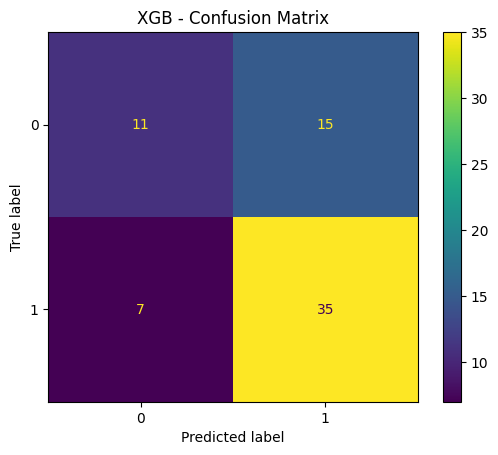


#5: SVM
    AUROC: 0.717
    Best Hyperparameters:
        memory: None
        steps: [('standardscaler', StandardScaler()), ('svc', SVC(C=0.1, probability=True))]
        transform_input: None
        verbose: False
        standardscaler: StandardScaler()
        svc: SVC(C=0.1, probability=True)
        standardscaler__copy: True
        standardscaler__with_mean: True
        standardscaler__with_std: True
        svc__C: 0.1
        svc__break_ties: False
        svc__cache_size: 200
        svc__class_weight: None
        svc__coef0: 0.0
        svc__decision_function_shape: ovr
        svc__degree: 3
        svc__gamma: scale
        svc__kernel: rbf
        svc__max_iter: -1
        svc__probability: True
        svc__random_state: None
        svc__shrinking: True
        svc__tol: 0.001
        svc__verbose: False


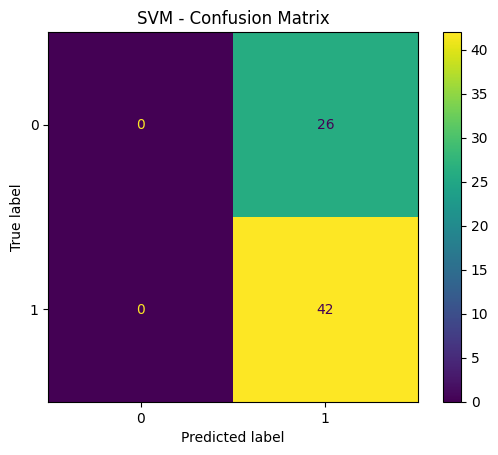


#2: RF
    AUROC: 0.690
    Best Hyperparameters:
        bootstrap: True
        ccp_alpha: 0.0
        class_weight: balanced
        criterion: gini
        max_depth: 3
        max_features: sqrt
        max_leaf_nodes: None
        max_samples: None
        min_impurity_decrease: 0.0
        min_samples_leaf: 4
        min_samples_split: 10
        min_weight_fraction_leaf: 0.0
        monotonic_cst: None
        n_estimators: 50
        n_jobs: None
        oob_score: False
        random_state: 42
        verbose: 0
        warm_start: False


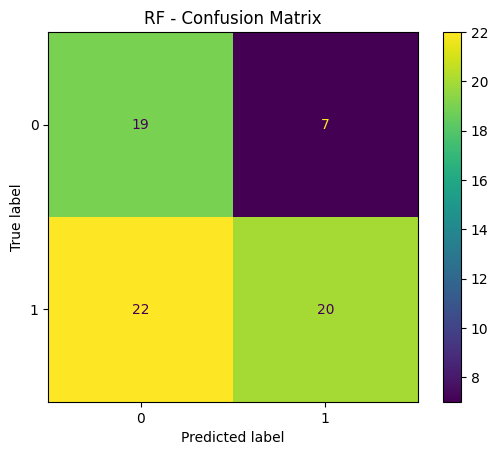

In [5524]:
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


# === 1. Initialize results container ===
results = []

# === 2. Evaluate each best-tuned model on test set ===
for name, model in best_models.items():
    y_pred = model.predict(X_test_top)
    y_proba = model.predict_proba(X_test_top)[:, 1]

    results.append({
        'Model': name,
        'Precision': round(precision_score(y_test, y_pred, zero_division=0), 3),
        'Recall': round(recall_score(y_test, y_pred, zero_division=0), 3),
        'Accuracy': round(accuracy_score(y_test, y_pred), 3),
        'F1': round(f1_score(y_test, y_pred, zero_division=0), 3),
        'AUROC': round(roc_auc_score(y_test, y_proba), 3),
        'Estimator': model,
        'y_pred': y_pred  # For confusion matrix later
    })

# === 3. Create and sort results DataFrame ===
results_df = pd.DataFrame(results)
results_df_display = results_df[['Model', 'Precision', 'Recall', 'Accuracy', 'F1', 'AUROC']]
results_df_display = results_df_display.sort_values(by='AUROC', ascending=False)

# === 4. Display and export table ===
print("📊 Model Performance Summary:")
display(results_df_display)

# Save as Excel
excel_filename = "model_performance_summary_table_tuned.xlsx"
output_path = os.path.join(CACHE_DIR, excel_filename)
results_df_display.to_excel(output_path, index=False)

# === 5. Display hyperparameters and confusion matrices for top 3 ===
print("\n🏆 Top 3 Models by AUROC:")
for i, row in results_df_display.head(3).iterrows():
    model_name = row['Model']
    full_row = results_df[results_df['Model'] == model_name].iloc[0]
    estimator = full_row['Estimator']
    y_pred = full_row['y_pred']
    auc = row['AUROC']

    print(f"\n#{i + 1}: {model_name}")
    print(f"    AUROC: {auc:.3f}")
    print(f"    Best Hyperparameters:")
    for param, val in estimator.get_params().items():
        print(f"        {param}: {val}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"{model_name} - Confusion Matrix")
    plt.grid(False)
    plt.show()




📈 Feature Importance and SHAP Summary for Top 2 Models:


🔍 XGB:


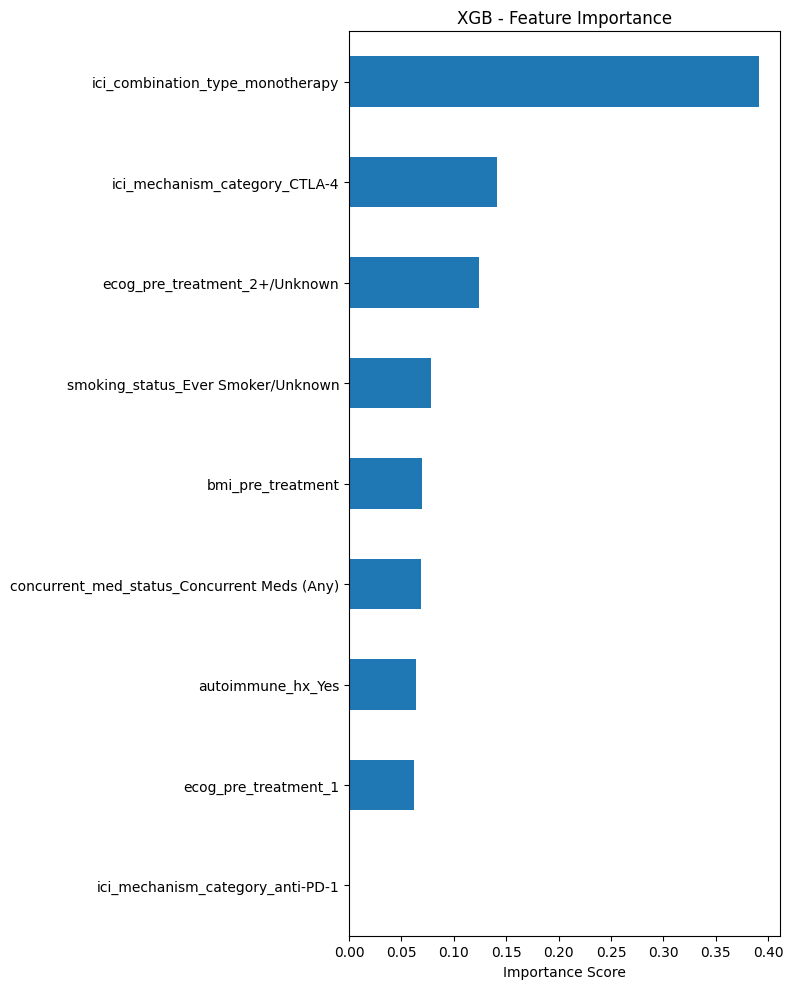

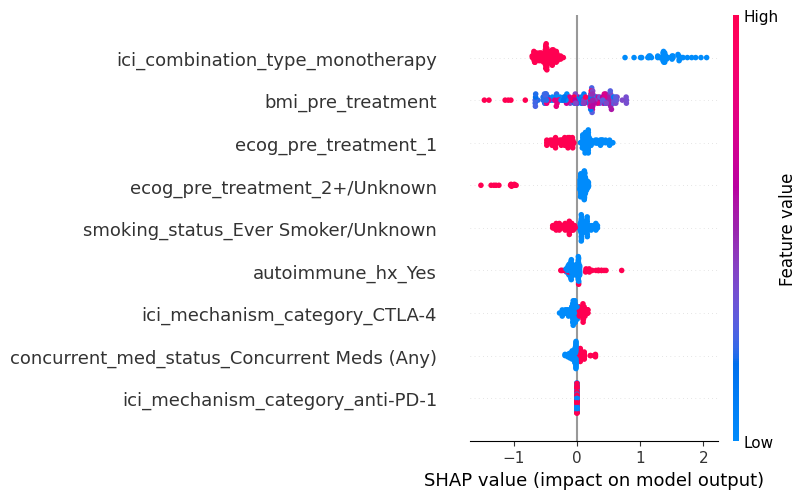


🔍 SVM:
🔁 Using permutation importance for SVM (no SHAP or .feature_importances_)


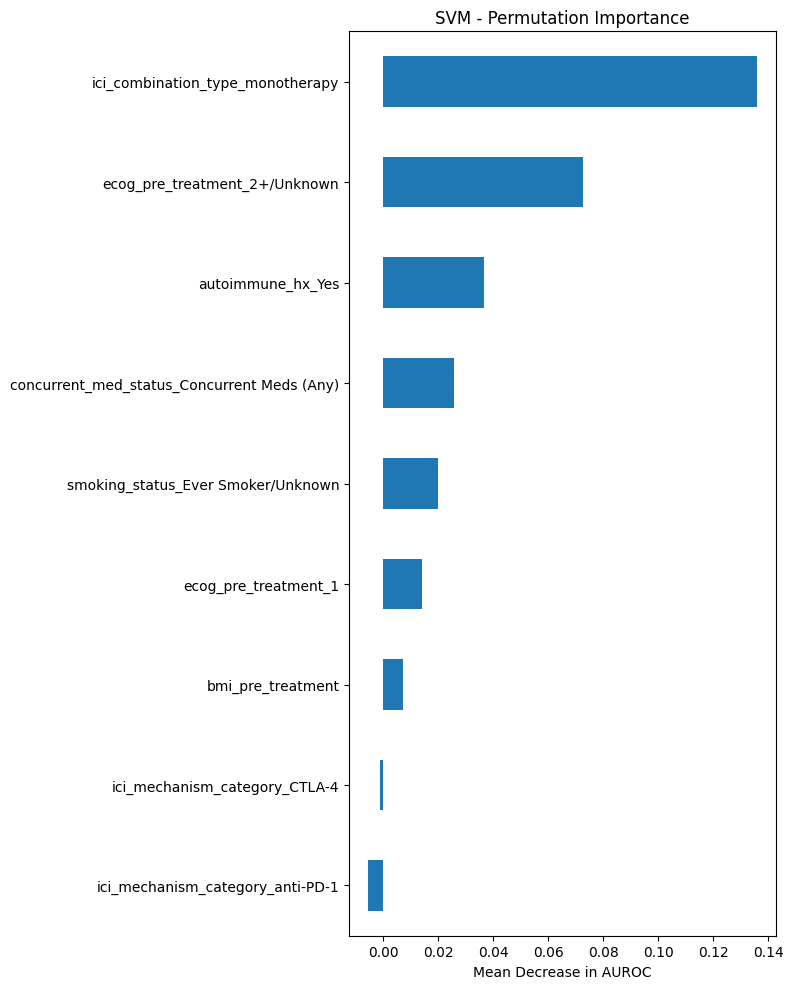

In [5525]:
import shap
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Define which models SHAP supports
SHAP_MODEL_CLASSES = (
    "xgboost", "sklearn.ensemble._forest", "sklearn.ensemble._gb", "lightgbm"
)

# === Unified Feature Importance Utility Functions ===

def plot_feature_importance(model, feature_names, title="Model"):
    if not hasattr(model, "feature_importances_"):
        return False  # Let fallback logic proceed
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

    plt.figure(figsize=(8, 10))
    feat_imp.plot(kind='barh')
    plt.title(f"{title} - Feature Importance")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()
    return True

def plot_shap_summary(model, X_train, title="Model"):
    try:
        if not any(cls in str(type(model)) for cls in SHAP_MODEL_CLASSES):
            return False
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
        shap.summary_plot(shap_values, X_train, plot_type="dot", max_display=20, show=True)
        return True
    except Exception as e:
        print(f"⚠️ SHAP plotting failed for {title}: {e}")
        return False

def plot_permutation_importance(model, X, y, title="Model"):
    try:
        result = permutation_importance(
            model, X, y, n_repeats=10, random_state=42, scoring='roc_auc'
        )
        perm = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=True)

        plt.figure(figsize=(8, 10))
        perm.plot(kind='barh')
        plt.title(f"{title} - Permutation Importance")
        plt.xlabel("Mean Decrease in AUROC")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Permutation importance failed for {title}: {e}")

# === Loop over top 2 models and apply best available explanation ===
print("\n📈 Feature Importance and SHAP Summary for Top 2 Models:\n")

# Ensure we extract from the actual results_df with the estimator
top2_models = results_df.sort_values(by='AUROC', ascending=False).head(2)

for _, row in top2_models.iterrows():
    model_name = row['Model']
    estimator = row['Estimator']

    print(f"\n🔍 {model_name}:")

    explained = False

    # Try feature importances
    explained |= plot_feature_importance(estimator, X_train_top.columns, title=model_name)

    # Try SHAP
    explained |= plot_shap_summary(estimator, X_train_top, title=model_name)

    # Fallback: permutation importance
    if not explained:
        print(f"🔁 Using permutation importance for {model_name} (no SHAP or .feature_importances_)")
        plot_permutation_importance(estimator, X_test_top, y_test, title=model_name)
